In [1]:
%matplotlib inline
import xarray as xr
import cmocean as cmo
import pandas as pd
from glob import glob

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from matplotlib.markers import MarkerStyle
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import cartopy
import cartopy.crs as ccrs
import shapely.geometry as sgeom
from cartopy.geodesic import Geodesic

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [2]:
### Define functions
def divide_longitude(lons, lats, var):
    '''Split data into sections east and west of the prime meridian'''
    
    lons_greater = ma.masked_greater(lons, -0.01)
    lons_lesser = ma.masked_less(lons, 0.)

    lats_greater = ma.MaskedArray(lats, mask=lons_greater.mask)
    lats_lesser = ma.MaskedArray(lats, mask=lons_lesser.mask)

    var_greater = ma.MaskedArray(var, mask=lons_greater.mask)
    var_lesser = ma.MaskedArray(var, mask=lons_lesser.mask)
    
    return lons_greater, lons_lesser, lats_greater, lats_lesser, var_greater, var_lesser

def mask_land(lons, lats, bathy, var):
    '''Mask land (elevation above zero)'''
    
    bathy_land = ma.masked_greater(bathy, 0.)
    lons_land = ma.MaskedArray(lons, mask=bathy_land.mask)
    lats_land = ma.MaskedArray(lats, mask=bathy_land.mask)
    var_land = ma.MaskedArray(var, mask=bathy_land.mask)
    
    return lons_land, lats_land, var_land

def prepare_outline_plot(ax):
    ### Set extent and boundary
    ax.set_extent([-50, 35, -90, -50], ccrs.PlateCarree())
    
    ylim = [-90,-50]
    xlim = [-90,90]
    rect = mpath.Path([[xlim[0], ylim[0]],
                       [xlim[1], ylim[0]],
                       [xlim[1], ylim[1]],
                       [xlim[0], ylim[1]],
                       [xlim[0], ylim[0]],
                       ]).interpolated(40)
    proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    
    ### Coastline
    ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=2)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=14)
    
    ### Gridlines
    # -60, -30, 0, 30, 60 W/E (only lines)
    gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
    gl0.ylocator = mticker.FixedLocator([])

    # 90, 80, 70, 60 S (only lines)
    gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl1.xlocator = mticker.FixedLocator([])
    gl1.ylocator = mticker.FixedLocator(np.arange(-90,-59,10))

    # 50 S (only lines)
    gl2 = ax.gridlines(linestyle='-', linewidth=1, color='k', draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl2.xlocator = mticker.FixedLocator([])
    gl2.ylocator = mticker.FixedLocator(np.arange(-50,-49,10))
    
    return ax

def prepare_outline_plot_zoom(ax):
    ### Set extent and boundary
    ax.set_extent([-60, -30, -78, -60], ccrs.PlateCarree())
    
    ### Coastline
    ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=2)
    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=14)
    
    ### Gridlines
    # -60, -30, 0, 30, 60 W/E (only lines)
    gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
    gl0.ylocator = mticker.FixedLocator([])

    # 90, 80, 70, 60 S (only lines)
    gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl1.xlocator = mticker.FixedLocator([])
    gl1.ylocator = mticker.FixedLocator(np.arange(-90,-59,10))

    # 50 S (only lines)
    gl2 = ax.gridlines(linestyle='-', linewidth=1, color='k', draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
    gl2.xlocator = mticker.FixedLocator([])
    gl2.ylocator = mticker.FixedLocator(np.arange(-50,-49,10))
    
    return ax

def prepare_subplot_SPS(ax):
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.contour(lons[:760,:], lats[:760,:], bath[:760,:], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)
    ax.plot(x696, y696, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=2) # Site 696
    return ax

### Settings plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# General settings

In [3]:
### Locations
x696p, y696p = -42.933067, -61.849083   # present-day
x696, y696 = -57., -67.5                # paleo lon/lat visually
gcd = (np.deg2rad(0.1)*6371e3)   # gridcell distance [m]

In [4]:
# Forwards
lonsfw = np.array([-55., -50., -45., -40., -35., -30., -25., -20.,
                   -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.,
                    25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,
                   -57.82330253])#, -59.25, -60.08662877, -60.01036191, -58.82106809])
latsfw = np.array([-77.99537227, -78.45787684, -79.17977465, -79.75459498, -79.99027112, -80.07689735, -79.9997914 , -80.12097168,
                   -79.24559138, -78.39033646, -77.33178711, -76.13251966, -75.17986379, -74.68456009, -73.6896764 , -73.53134648,
                   -72.9724492 , -72.3117251 , -72.29006817, -72.16268516, -70.86573029, -68.58359528, -68.58359528, -66.59729004,
                   -77.])#        , -75.        , -73.        , -71.        , -69.        ])
# Backwards
lonsbw = np.array([-57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                   -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                   -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                   -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221,
                   -57.04998779, -57.0249939, -57., -56.9750061, -56.95001221])
latsbw = np.array([-67.5270462, -67.5270462, -67.5270462, -67.5270462, -67.5270462,
                   -67.5164814, -67.5164814, -67.5164814, -67.5164814, -67.5164814,
                   -67.5059166, -67.5059166, -67.5059166, -67.5059166, -67.5059166,
                   -67.49535179, -67.49535179, -67.49535179, -67.49535179, -67.49535179,
                   -67.48478699, -67.48478699, -67.48478699, -67.48478699, -67.48478699])

In [5]:
# Load data
topo = xr.open_dataset('/nethome/5867800/grid/adapted_bathymetry.nc')

# Load variables
lats = topo.variables['T_LAT_2D'][:,:]
lons = topo.variables['T_LON_2D'][:,:]
bath = topo.variables['Bathymetry'][:,:]

### Fix latitudes, longitudes and bathymetry
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(lons, lats, bath)
lons = np.concatenate((lonsg[:,2650:], lonsg[:,:850], lonsl[:,850:2650]), axis=1) # -179.95 to -85.05, -84.95 to -0.05, 0.05 to 179.95
lats = np.concatenate((latsg[:,2650:], latsg[:,:850], latsl[:,850:2650]), axis=1)
bath = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

# Thesis figures

## Forwards

In [60]:
### Thesis figures
C3g  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C3g.zarr')   # grounding, C3 (1000)
C4g  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C4g.zarr')   # grounding, C4 (10000)
C5g  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C5g.zarr')   # grounding, C5 (100000)
SF   = xr.open_zarr('/nethome/5867800/active/29p_5y_surf_30d_1hdtar_C4.zarr')   # surface no grounding, C4 (10000)

### Supplements
PF   = xr.open_zarr('/nethome/5867800/passive/29p_5y_30d_1hdtar.zarr')          # passive
C4gs = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C4gs.zarr')  # grounding, C4 changed loc (10000)
C5a  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C5ga.zarr')  # grounding, C5 adapted Mb (100000)

### Not shown
C1g  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C1g.zarr')   # grounding, C1 (10)
C2g  = xr.open_zarr('/nethome/5867800/active/29p_5y_int_30d_1hdtar_C2g.zarr')   # grounding, C2 (100)

In [61]:
### Remove release locations North Graham Land
remove_NGL = np.sort(np.concatenate((np.arange(25, len(C3g['trajectory']), 29),
                                     np.arange(26, len(C3g['trajectory']), 29),
                                     np.arange(27, len(C3g['trajectory']), 29),
                                     np.arange(28, len(C3g['trajectory']), 29))))

### Select trajectories
# Main figures
mask = ~C3g['trajectory'].isin(remove_NGL)
C3g_filtered = C3g.sel(trajectory=mask)
mask = ~C4g['trajectory'].isin(remove_NGL)
C4g_filtered = C4g.sel(trajectory=mask)
mask = ~C5g['trajectory'].isin(remove_NGL)
C5g_filtered = C5g.sel(trajectory=mask)
mask = ~SF['trajectory'].isin(remove_NGL)
SF_filtered = SF.sel(trajectory=mask)

# Supplements
mask = ~PF['trajectory'].isin(remove_NGL)
PF_filtered = PF.sel(trajectory=mask)
mask = ~C4gs['trajectory'].isin(remove_NGL)
C4gs_filtered = C4gs.sel(trajectory=mask)
mask = ~C5a['trajectory'].isin(remove_NGL)
C5a_filtered = C5a.sel(trajectory=mask)

# Other
mask = ~C1g['trajectory'].isin(remove_NGL)
C1g_filtered = C1g.sel(trajectory=mask)
mask = ~C2g['trajectory'].isin(remove_NGL)
C2g_filtered = C2g.sel(trajectory=mask)

### Trajectories

Figure 3.1

| []() | []() | []() |
|------|------|------|
|  C3g |  C4g |  C5g |
|  C4d |  SF  |      |

In [8]:
data = [C3g_filtered, C4g_filtered, C5g_filtered,
        C4g_filtered, SF_filtered]
names = ['C3g', 'C4g', 'C5g',
         'C4gd', 'C4s']
labels = ['C3 icebergs', 'C4 icebergs', 'C5 icebergs',
          'C4 icebergs - doubled target distance', 'C4 icebergs - surface only']

Start preparing C3g...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C4g...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C5g...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C4gd...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C4s...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


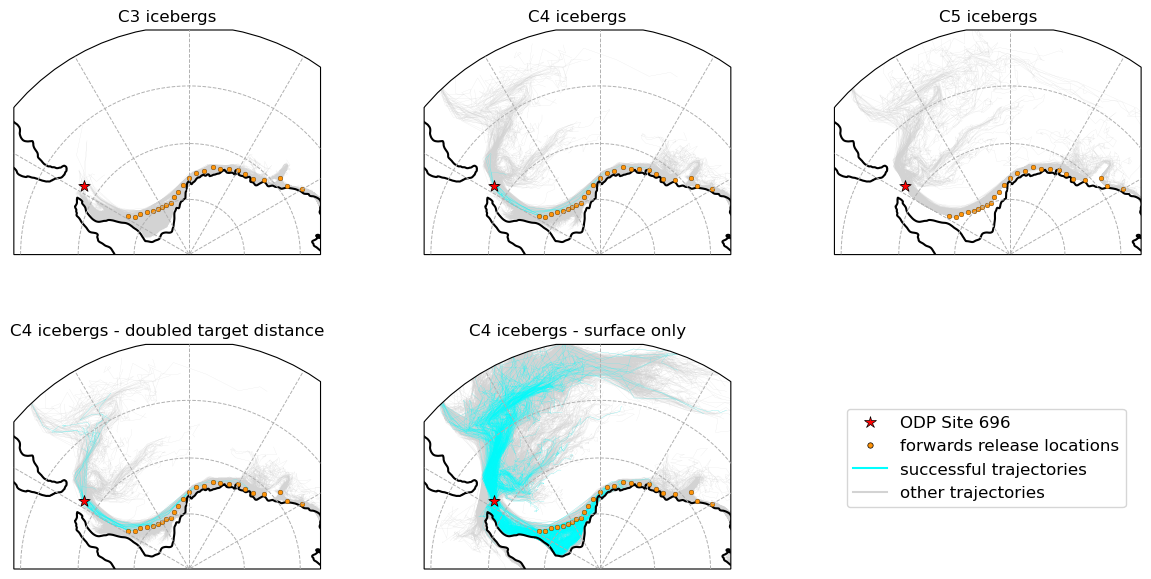

In [9]:
fig = plt.figure(figsize=(15,7))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(2, 2, 2))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(2, 2, 2))   # fill bottom row: 1 rows, 3 columns

axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1])]

for dat, name, label, ax in zip(data, names, labels, axes):
    print(f'Start preparing {name}...')

    ## Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ## Keep trajectories that reach within gridcell distance of ODP 696
    tst = np.tile(minvals,(len(dat['obs']),1))
    if name != 'C4gd':
        tlat = np.where(tst.T>gcd, np.nan, dat['lat'])
        tlon = np.where(tst.T>gcd, np.nan, dat['lon'])
    else:
        tlat = np.where(tst.T>2*gcd, np.nan, dat['lat'])
        tlon = np.where(tst.T>2*gcd, np.nan, dat['lon'])

    print(f'   data prepared, continue plotting...')

    ax = prepare_outline_plot(ax)
    ax.set_title(f'{str(label)}')

    ## Plot ODP
    ax.scatter(x696, y696, color='r', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=3) # Site 696

    ## Plot trajectories
    ax.plot(tlon.T, tlat.T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='cyan')
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=0, color='lightgrey')
    print(f'   other trajectories plotted...')

    ## Plot release locations
    ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3 ,s=12, edgecolor='k', linewidths=0.2)
    
    if name == 'C4s':
        handles, labels = ax.get_legend_handles_labels()
        ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
        handles.append(ODP)
        rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(15),
                     markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
        handles.append(rel)
        suc = Line2D([0], [0], label='successful trajectories', color='cyan')
        handles.append(suc)
        oth = Line2D([0], [0], label='other trajectories', color='lightgrey')
        handles.append(oth)
        ax.legend(handles=handles, bbox_to_anchor=(1.35, .75), fontsize='12')

print('Saving figure...')
plt.savefig(f'figures/Thesis/FW_Trajectories2.png', bbox_inches='tight', dpi=450)
print(f'Figure saved.')
plt.show()

Figure S3.1

| []() | []() | []() |
|------|------|------|
|  PF  | C4gs | C5ga |

In [10]:
data_sup = [PF_filtered, C4gs_filtered, C5a_filtered]
names_sup = ['PF', 'C4gs', 'C5a']
labels_sup = ['Passive particles', 'C4 icebergs - shifted position', 'C5 icebergs - adapted basal melt']

Start preparing PF...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C4gs...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C5a...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


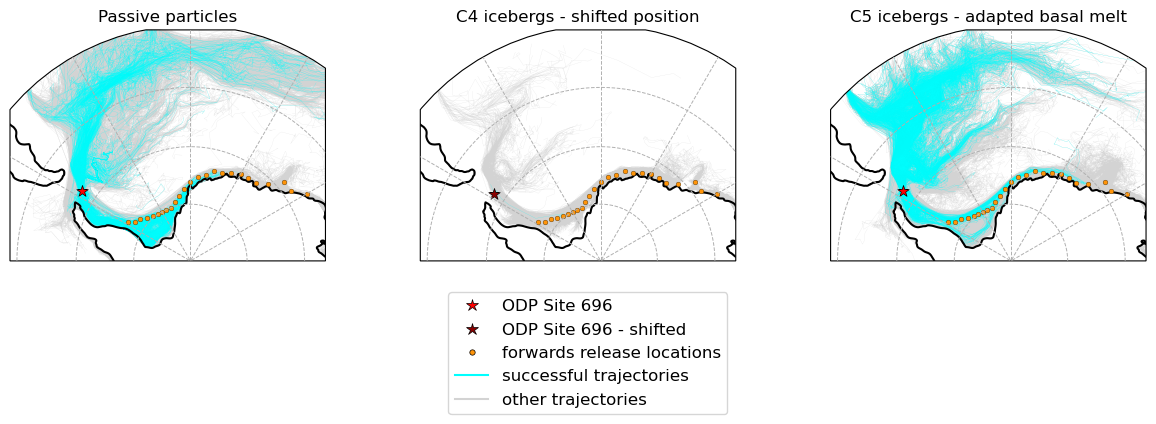

In [11]:
fig = plt.figure(figsize=(15,3))

gs = GridSpec(1, 1)   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(2, 2, 2))   # fill top row: 1 rows, 3 columns

axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2])]

for dat, name, label, ax in zip(data_sup, names_sup, labels_sup, axes):
    print(f'Start preparing {name}...')

    # Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ## Keep trajectories that reach within gridcell distance of ODP 696
    tst = np.tile(minvals,(len(dat['obs']),1))
    tlat = np.where(tst.T>gcd, np.nan, dat['lat'])
    tlon = np.where(tst.T>gcd, np.nan, dat['lon'])

    print(f'   data prepared, continue plotting...')

    ax = prepare_outline_plot(ax)
    ax.set_title(f'{str(label)}')

    ## Plot ODP
    if name == 'C4gs':
        ax.scatter(x696-1, y696-0.5, color='darkred', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=3)
    else:
        ax.scatter(x696, y696, color='r', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=3)

    ## Plot trajectories
    ax.plot(tlon.T, tlat.T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='cyan')
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=0, color='lightgrey')
    print(f'   other trajectories plotted...')

    ## Plot release locations
    ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3 ,s=12, edgecolor='k', linewidths=0.2)
    
    if name == 'C4gs':
        handles, labels = ax.get_legend_handles_labels()
        ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
        handles.append(ODP)
        ODPs = Line2D([0], [0], label='ODP Site 696 - shifted', marker='*', markersize=np.sqrt(75),
                     markeredgecolor='k', markerfacecolor='darkred', markeredgewidth=.5, linestyle='')
        handles.append(ODPs)
        rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(15),
                     markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
        handles.append(rel)
        suc = Line2D([0], [0], label='successful trajectories', color='cyan')
        handles.append(suc)
        oth = Line2D([0], [0], label='other trajectories', color='lightgrey')
        handles.append(oth)
        ax.legend(handles=handles, bbox_to_anchor=(1., -.1), fontsize='12')

print('Saving figure...')
plt.savefig(f'figures/Thesis/FW_Trajectories_sup2.png', bbox_inches='tight', dpi=450)
print(f'Figure saved.')
plt.show()

### Percentages

In [12]:
cols = ['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499']

Figure 3.2

In [15]:
data = [C1g_filtered, C2g_filtered, C3g_filtered, C4g_filtered, C5g_filtered, C4g_filtered, SF_filtered]
names = ['C1g', 'C2g', 'C3g', 'C4g', 'C5g', 'C4gd', 'SF']
labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C4 - doubled target distance', 'C4 - surface only']

Start plotting C1g...
   data prepared, continue plotting...
Start plotting C2g...
   data prepared, continue plotting...
Start plotting C3g...
   data prepared, continue plotting...
Start plotting C4g...
   data prepared, continue plotting...
Start plotting C5g...
   data prepared, continue plotting...
Start plotting C4gd...
   data prepared, continue plotting...
Start plotting SF...
   data prepared, continue plotting...
   figure saved.


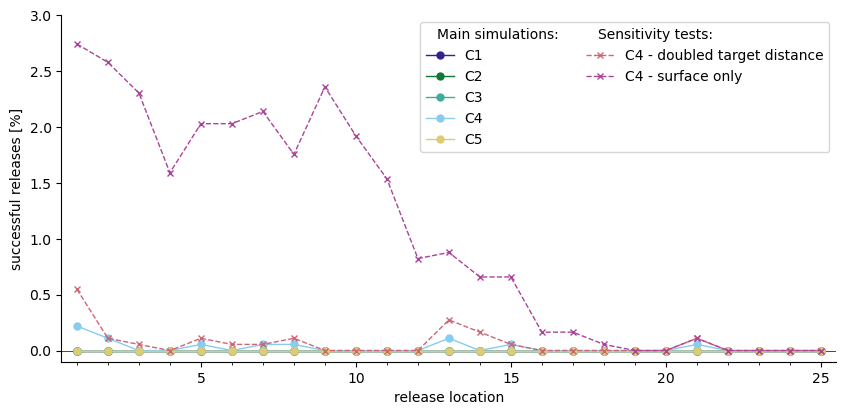

In [16]:
### Start figure
fig, ax = plt.subplots(1, 1, figsize=(10,4.5))

for dat, name, label, col in zip(data, names, labels, cols):
    print(f'Start plotting {name}...')
    
    ### Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lonsfw, int(len(dat['trajectory'])/len(lonsfw)))
    latsar = np.tile(latsfw, int(len(dat['trajectory'])/len(latsfw)))
    
    ### Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ### Create arrays with release locations of trajectories reaching within grid cell distance
    if name != 'C4gd':
        mask = (minvals <= gcd)
    else:
        mask = (minvals <= 2*gcd)
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    ### Create dataframe to group release coordinates
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)

    ### Calculate fraction of releases reaching ODP
    cnt = np.bincount(np.searchsorted(np.sort(lonsfw), df['lon']), minlength=len(lonsfw))
    frac = cnt / (len(dat['trajectory']) / len(lonsfw))

    df2 = pd.DataFrame(data={'lon': np.sort(lonsfw),
                             'lat': np.array([x for _, x in sorted(zip(lonsfw, latsfw))]),
                             'cnt': cnt,
                             'frac': frac})
    
    ### Change order of release locations (0=closest, 28=furthest)
    df2.reset_index(drop=True, inplace=True)
    
    print(f'   data prepared, continue plotting...')
    
    ### Plot points
    if name == 'C4gd' or name == 'C4gs' or name == 'SF':
        ax.plot(df2.index, df2['frac']*100., linestyle='--', marker='x', linewidth=1, markersize=5, label=f'{label}', zorder=5, color=col)
    else:
        ax.plot(df2.index, df2['frac']*100., 'o-', linewidth=1, markersize=5, label=f'{label}', zorder=5, color=col)
    ax.set_yscale('linear')

### Plot horizontal line through y=0
ax.axhline(0, linewidth=.5, color='k', zorder=0)

### Fix labels
ax.set_xticks([4, 9, 14, 19, 24])
ax.set_xticklabels(['5', '10', '15', '20', '25'])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23], minor=True)

### Set limits
ax.set_xlim(-0.5,24.5)
ax.set_ylim(-0.1, 3.)

### End figure
ax.set_xlabel('release location')
ax.set_ylabel('successful releases [%]')

### Plot legend
h, l = ax.get_legend_handles_labels()               # get handles/labels from plot
ph = [ax.plot([], marker="", ls="")[0]]*2           # create empty labels 
handles = ph[:1] + h[:5] + ph[1:] + h[5:] + ph[:]   # set new handles
labs = ['Main simulations:'] + l[:5] + ['Sensitivity tests:'] + l[5:] + [''] + ['']

leg = ax.legend(handles, labs, ncol=2)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

### Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.savefig(f'figures/Thesis/FW-int_PCT-c.png', bbox_inches='tight', dpi=600)
plt.savefig(f'figures/Thesis/FW-int_PCT-c.pdf', bbox_inches='tight', dpi=600)
print(f'   figure saved.')
plt.show()

Appendix B

In [17]:
for dat, name in zip(data, names):
    
    ### Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lonsfw, int(len(dat['trajectory'])/len(lonsfw)))
    latsar = np.tile(latsfw, int(len(dat['trajectory'])/len(latsfw)))
    
    ### Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ### Create arrays with release locations of trajectories reaching within grid cell distance
    if name != 'C4gd':
        mask = (minvals <= gcd)
    else:
        mask = (minvals <= 2*gcd)
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    ### Create dataframe to group release coordinates
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)

    ### Calculate fraction of releases reaching ODP
    tot = len(dat['trajectory'])
    cnt = np.bincount(np.searchsorted(np.sort(lonsfw), df['lon']), minlength=len(lonsfw))
    sm = sum(cnt)
    cnt = len(df)
    frac = cnt / tot
    print(f'Of the in total {tot} trajectories of {name}, {sm} = {cnt} or {frac*100:1.3f}% are successful.')

Of the in total 45575 trajectories of C1g, 0 = 0 or 0.000% are successful.
Of the in total 45575 trajectories of C2g, 0 = 0 or 0.000% are successful.
Of the in total 45575 trajectories of C3g, 0 = 0 or 0.000% are successful.
Of the in total 45575 trajectories of C4g, 13 = 13 or 0.029% are successful.
Of the in total 45575 trajectories of C5g, 0 = 0 or 0.000% are successful.
Of the in total 45575 trajectories of C4gd, 30 = 30 or 0.066% are successful.
Of the in total 45575 trajectories of SF, 483 = 483 or 1.060% are successful.


Figure S3.2

In [18]:
cols_sup = ['#332288', '#117733', '#44AA99', '#88CCEE']

In [20]:
data_sup = [PF_filtered, C4gs_filtered, C5a_filtered]
names_sup = ['PF', 'C4gs', 'C5a']
labels_sup = ['Passive particles', 'C4 icebergs - shifted position', 'C5 icebergs - adapted basal melt']

Start plotting PF...
   data prepared, continue plotting...
Start plotting C4gs...
   data prepared, continue plotting...
Start plotting C5a...
   data prepared, continue plotting...
   figure saved.


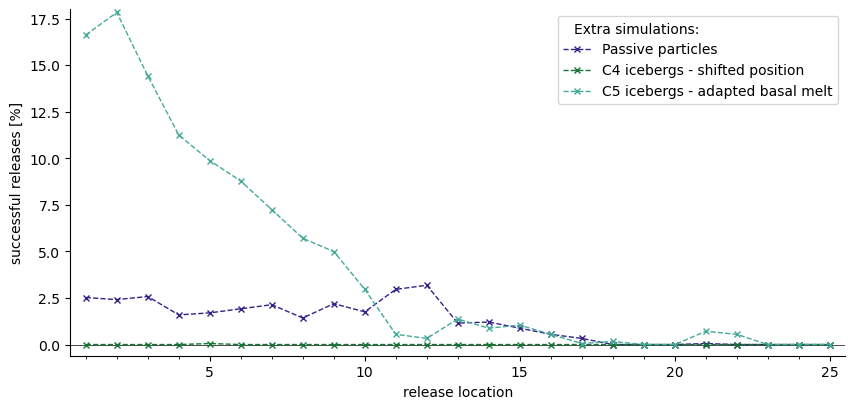

In [21]:
### Start figure
fig, ax = plt.subplots(1, 1, figsize=(10,4.5))

for dat, name, label, col in zip(data_sup, names_sup, labels_sup, cols_sup):
    print(f'Start plotting {name}...')
    
    ### Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lonsfw, int(len(dat['trajectory'])/len(lonsfw)))
    latsar = np.tile(latsfw, int(len(dat['trajectory'])/len(latsfw)))
    
    ### Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ### Create arrays with release locations of trajectories reaching within grid cell distance
    mask = (minvals <= gcd)
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    ### Create dataframe to group release coordinates
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)

    ### Calculate fraction of releases reaching ODP
    cnt = np.bincount(np.searchsorted(np.sort(lonsfw), df['lon']), minlength=len(lonsfw))
    frac = cnt / (len(dat['trajectory']) / len(lonsfw))

    df2 = pd.DataFrame(data={'lon': np.sort(lonsfw),
                             'lat': np.array([x for _, x in sorted(zip(lonsfw, latsfw))]),
                             'cnt': cnt,
                             'frac': frac})
    
    ### Change order of release locations
    df2.reset_index(drop=True, inplace=True)
    
    print(f'   data prepared, continue plotting...')
    
    ### Plot points
    ax.plot(df2.index, df2['frac']*100., linestyle='--', marker='x', linewidth=1, markersize=5, label=f'{label}', zorder=5, color=col)
    ax.set_yscale('linear')

### Plot horizontal line through y=0
ax.axhline(0, linewidth=.5, color='k', zorder=0)

### Fix labels
ax.set_xticks([4, 9, 14, 19, 24])
ax.set_xticklabels(['5', '10', '15', '20', '25'])
ax.set_xticks([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23], minor=True)

### Set limits
ax.set_xlim(-0.5,24.5)
ax.set_ylim(-18./30.,18.)

### End figure
ax.set_xlabel('release location')
ax.set_ylabel('successful releases [%]')

### Plot legend
h, l = ax.get_legend_handles_labels()               # get handles/labels from plot
ph = [ax.plot([], marker="", ls="")[0]]*4           # create empty labels 
handles = ph[:1] + h[:5] + ph[:]                    # set new handles
labs = ['Extra simulations:'] + l[:]

leg = ax.legend(handles, labs, ncol=1)

for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

### Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.savefig(f'figures/Thesis/FW-int_PCT-c-sup.png', bbox_inches='tight', dpi=600)
plt.savefig(f'figures/Thesis/FW-int_PCT-c-sup.pdf', bbox_inches='tight', dpi=600)
print(f'   figure saved.')
plt.show()

Table S3.1

In [22]:
for dat, name in zip(data_sup, names_sup):
    
    ### Create arrays with release locations of all trajectories individually
    lonsar = np.tile(lonsfw, int(len(dat['trajectory'])/len(lonsfw)))
    latsar = np.tile(latsfw, int(len(dat['trajectory'])/len(latsfw)))
    
    ### Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)

    ### Create arrays with release locations of trajectories reaching within grid cell distance
    mask = (minvals <= gcd)
    lonsar[~mask] = np.nan
    latsar[~mask] = np.nan
    
    ### Create dataframe to group release coordinates
    df = pd.DataFrame(data={'lat': latsar, 'lon': lonsar})
    df.dropna(inplace=True)

    ### Calculate fraction of releases reaching ODP
    tot = len(dat['trajectory'])
    cnt = np.bincount(np.searchsorted(np.sort(lonsfw), df['lon']), minlength=len(lonsfw))
    sm = sum(cnt)
    cnt = len(df)
    frac = cnt / tot
    print(f'Of the in total {tot} trajectories of {name}, {sm} = {cnt} or {frac*100:1.3f}% are successful.')

Of the in total 45575 trajectories of PF, 557 = 557 or 1.222% are successful.
Of the in total 45575 trajectories of C4gs, 1 = 1 or 0.002% are successful.
Of the in total 45575 trajectories of C5a, 1930 = 1930 or 4.235% are successful.


### Iceberg lifetime

Appendix F

In [124]:
# Date of release
dr = pd.date_range(start='01/01/2038', end='12/31/2042', freq='d') # exact dates not relevant, only frequency !!! US format !!!
dates1 = dr[(dr.day != 29) | (dr.month != 2)]
dates = dates1[(dates1.day != 1) | (dates1.month != 3) | (dates1.year != 2040)] # this datafile is empty
timestamps = np.expand_dims(np.array(dates), axis=1)
timear = np.repeat(timestamps[:-1], len(lonsfw))                  # array of release times

In [191]:
def half_life(dat, mass):
    drp = dat.drop_vars(['Mbr', 'Mer', 'Mvr', 'distance', 'lat', 'lon', 'z'])
    sel = drp.copy()
    half_1 = sel.isel(obs=0)
    
    # Add initial values to dataset
    half_1['time'].values = timear
    half_1['M'].values = np.ones(len(timear)) * mass
    half_f = xr.concat([half_1, sel], dim='obs')
    
    # Obtain indices where last value of true
    M_sel = half_f.where(half_f['M'] > (mass / 2.))
    not_null = M_sel['M'].notnull()                                          # True values
    tst = not_null.to_numpy()
    indices = tst.shape[1] - np.argmax(tst[:, ::-1], axis=1)                 # index of last True value (first value smaller than half)
    all_false = np.logical_not(tst).all(axis=1)
    indices[all_false] = 0                                                   # set to 0 if all False
    
    # Number of days since release to half mass
    days = np.ones(len(timear))
    for i, ind in enumerate(indices):
        if ind == 63:
            days[i] = np.nan
        else:
            days[i] = (half_f['time'][i, ind].values - half_f['time'][i, 0].values).astype('timedelta64[D]')
    
    return days

In [200]:
C4g_cp = C4g_filtered.copy()
C4g_cp = C4g_cp.drop(['Mvr', 'Mbr', 'Mer'])

C4g_cp['dur'] = (('trajectory', 'obs'), np.zeros_like(C4g_cp['time'].astype('timedelta64[D]')))
C4g_cp['dur'] = (('trajectory', 'obs'), (C4g_cp['time'].values - timear[:, np.newaxis]).astype('timedelta64[D]'))

Time since release of icebergs C4

In [25]:
dat = C4g_cp
name = 'C4'
label = 'C4 icebergs'

Start plotting C4...
   other trajectories plotted...
Saving figure...
Figure saved.


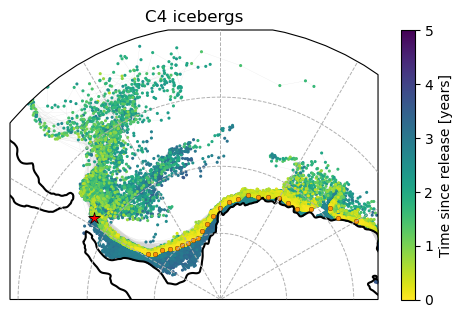

In [26]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(6,3.5))

print(f'Start plotting {name}...')

ax = prepare_outline_plot(ax)
ax.set_title(f'{str(label)}')

## Plot ODP
ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3) # Site 696

## Plot release locations
ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3, label='forwards',s=12, edgecolor='k', linewidths=0.2)

## Plot trajectories
ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=0, color='lightgrey')
print(f'   other trajectories plotted...')

cm = ax.scatter(dat['lon'], dat['lat'], transform=ccrs.PlateCarree(), s=1.5, zorder=1, c=dat['dur']/86400e9,
                cmap='viridis_r', vmin=0, vmax=365*5)
fig.colorbar(cm, ticks=[0, 365, 2*365, 3*365, 4*365, 5*365], format=mticker.FixedFormatter(['0', '1', '2', '3', '4', '5']),
             label='Time since release [years]')

print('Saving figure...')
plt.savefig(f'figures/Thesis/C4_lifetime.png', bbox_inches='tight', dpi=600)
print(f'Figure saved.')
plt.show()

Maximum lifetime for icebergs C4

In [201]:
C4maxs = C4g_cp['dur'].max(skipna=True, dim='obs')

In [161]:
days4 = half_life(C4g_filtered, 10000*10000/1.5*500*850.0)
days4 = np.where(np.isnat(days4.astype('timedelta64[D]')), np.nan, days4)
np.nanmean(days4)

345.2257744134858

Saving figure...
   saved as png, now save as pdf...
Figure saved.


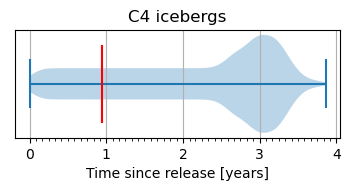

In [204]:
fig = plt.figure(figsize=(4.2,1.4))
ax = plt.axes()

# plot violin plot
ax.violinplot(C4maxs.values/np.timedelta64(1,'D'), vert=False)
ax.axvline(np.nanmean(days4), ymin=.15, ymax=.85, c='r')

ax.xaxis.grid(True)
ax.set_xticks([0, 365, 2*365, 3*365, 4*365], labels=['0', '1', '2', '3', '4'])
ax.set_xticks([0,31,59,90,120,151,181,212, 243, 273, 304, 334,
               396, 424, 455, 485, 516, 546, 577, 608, 638, 669, 699, 
               761, 789, 820, 850, 881, 911, 942, 973, 1003, 1034, 1064,
               1126, 1154, 1185, 1215, 1246, 1276, 1307, 1338, 1368, 1399, 1429], minor=True)

ax.set_yticks([])
ax.set_xlabel('Time since release [years]')

ax.set_title('C4 icebergs')

print('Saving figure...')
plt.savefig(f'figures/Thesis/C4_lifetimev.png', bbox_inches='tight', dpi=600)
print(f'   saved as png, now save as pdf...')
plt.savefig(f'figures/Thesis/C4_lifetimev.pdf', bbox_inches='tight', dpi=600)
print(f'Figure saved.')

plt.show()

Maximum lifetime for icebergs C3

In [194]:
C3g_cp = C3g_filtered.copy()
C3g_cp = C3g_cp.drop(['Mvr', 'Mbr', 'Mer', 'lat', 'lon', 'M'])

C3g_cp['dur'] = (('trajectory', 'obs'), np.zeros_like(C3g_cp['time'].astype('timedelta64[D]')))
C3g_cp['dur'] = (('trajectory', 'obs'), (C3g_cp['time'].values - timear[:, np.newaxis]).astype('timedelta64[D]'))

C3maxs = C3g_cp['dur'].max(skipna=True, dim='obs')

ValueError: operands could not be broadcast together with shapes (45575,8) (45550,1) 

In [175]:
days3 = half_life(C3g_filtered, 1000*1000/1.5*200*850.0)
days3 = np.where(np.isnat(days3.astype('timedelta64[D]')), np.nan, days3)
np.nanmean(days3)

Saving figure...
   saved as png, now save as pdf...
Figure saved.


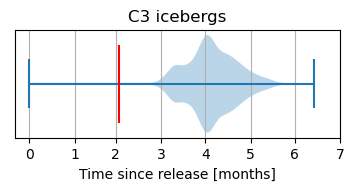

In [205]:
fig = plt.figure(figsize=(4.2,1.4))
ax = plt.axes()

# plot violin plot
ax.violinplot(C3maxs.values/np.timedelta64(1,'D'), vert=False)
ax.axvline(np.nanmean(days3), ymin=.15, ymax=.85, c='r')

ax.xaxis.grid(True)
ax.set_xticks([0,31,59,90,120,151,181,212], labels=['0', '1', '2', '3', '4', '5', '6', '7'])

ax.set_yticks([])
ax.set_xlabel('Time since release [months]')

ax.set_title('C3 icebergs')

print('Saving figure...')
plt.savefig(f'figures/Thesis/C3_lifetime.png', bbox_inches='tight', dpi=600)
print(f'   saved as png, now save as pdf...')
plt.savefig(f'figures/Thesis/C3_lifetime.pdf', bbox_inches='tight', dpi=600)
print(f'Figure saved.')

plt.show()

### Melt

In [241]:
dat = C4g_filtered
name = 'C4g'

In [8]:
# Load data
Mv = C4g_filtered['Mvr'].values
Mb = C4g_filtered['Mbr'].values
Me = C4g_filtered['Mer'].values
plon = C4g_filtered['lon'].values
plat = C4g_filtered['lat'].values

In [9]:
melts = [Mv, Mb, Me, Mv+Mb+Me]
terms = ['Buoyant convection', 'Basal melt', 'Wave erosion', 'Total melt']

Figure 4.1

Start preparation C4...
   trajectories...
   scatter...
   colorbars...
   and finalise.


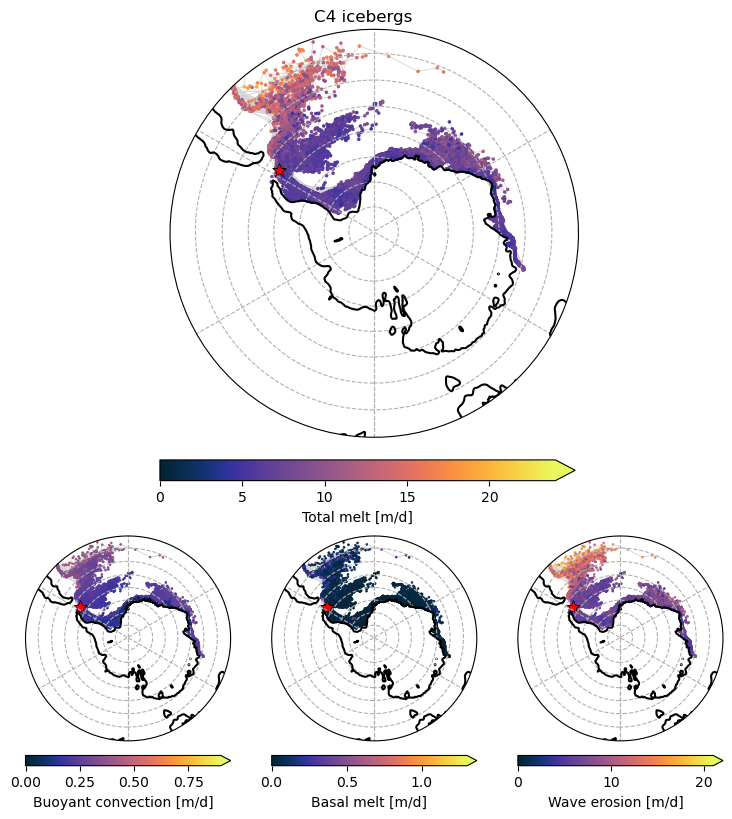

In [242]:
name = 'C4'
label = 'C4 icebergs'

### Plot fields and icebergs
fig = plt.figure(figsize=(9,10))

# Setup axes
gs = gridspec.GridSpec(5,3)
ax = {}
ax0 = fig.add_subplot(gs[0:3,0:3], projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(gs[3:,0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(gs[3:,1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(gs[3:,2], projection=ccrs.SouthPolarStereo())

plt.suptitle(f'{label}', y=0.9)

## Prepare
print(f'Start preparation {name}...')
ax0 = prepare_subplot_SPS(ax0)
normalize0 = colors.Normalize(vmin=0., vmax=24.) # total
ax1 = prepare_subplot_SPS(ax1)
normalize1 = colors.Normalize(vmin=0., vmax=.9) # buoyant
ax2 = prepare_subplot_SPS(ax2)
normalize2 = colors.Normalize(vmin=0., vmax=1.3) # basal
ax3 = prepare_subplot_SPS(ax3)
normalize3 = colors.Normalize(vmin=0., vmax=21.) # wave

## Trajectories
print(f'   trajectories...')
ax0.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax1.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax2.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax3.plot(plon.T, plat.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)

## Points
print(f'   scatter...')
for i in range(len(dat['trajectory'])):
    cf0 = ax0.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mv+Mb+Me)[i,1:]*86400.,
                      cmap=cmo.cm.thermal, linewidth=.8, s=3, norm=normalize0, zorder=1)
    cf1 = ax1.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mv[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize1, zorder=1)
    cf2 = ax2.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Mb[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize2, zorder=1)
    cf3 = ax3.scatter(plon[i,1:], plat[i,1:], transform=ccrs.PlateCarree(), c=(Me[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize3, zorder=1)

## Colorbars
print(f'   colorbars...')
plt.colorbar(cf0, ax=ax0, label=f'Total melt [m/d]', orientation='horizontal', fraction=0.046, pad=0.05, extend='max')
plt.colorbar(cf1, ax=ax1, label=f'Buoyant convection [m/d]', orientation='horizontal', pad=0.05, extend='max')
plt.colorbar(cf2, ax=ax2, label=f'Basal melt [m/d]', orientation='horizontal', pad=0.05, extend='max')
plt.colorbar(cf3, ax=ax3, label=f'Wave erosion [m/d]', orientation='horizontal', pad=0.05, extend='max')

print(f'   and finalise.')
plt.savefig(f'figures/Thesis/FW-int_melt-{name}.png', bbox_inches='tight', dpi=600)
plt.show()

Figure S3.6

In [243]:
# Load data
Mvs = SF_filtered['Mvr'].values
Mbs = SF_filtered['Mbr'].values
Mes = SF_filtered['Mer'].values
plons = SF_filtered['lon'].values
plats = SF_filtered['lat'].values

In [244]:
meltss = [Mvs, Mbs, Mes, Mvs+Mbs+Mes]
terms = ['Buoyant convection', 'Basal melt', 'Wave erosion', 'Total melt']

Start preparation SF...
   trajectories...
   scatter...
   colorbars...
   and finalise.


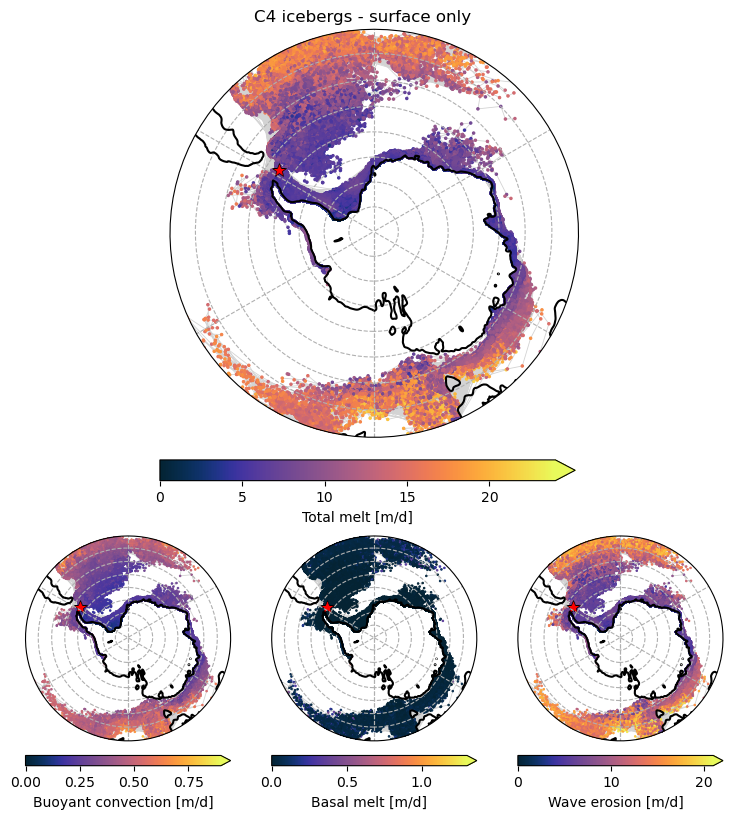

In [245]:
name = 'SF'
label = 'C4 icebergs - surface only'

### Plot fields and icebergs
fig = plt.figure(figsize=(9,10))

# Setup axes
gs = gridspec.GridSpec(5,3)
ax = {}
ax0 = fig.add_subplot(gs[0:3,0:3], projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(gs[3:,0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(gs[3:,1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(gs[3:,2], projection=ccrs.SouthPolarStereo())

plt.suptitle(f'{label}', y=0.9)

## Prepare
print(f'Start preparation {name}...')
ax0 = prepare_subplot_SPS(ax0)
normalize0 = colors.Normalize(vmin=0., vmax=24.) # total
ax1 = prepare_subplot_SPS(ax1)
normalize1 = colors.Normalize(vmin=0., vmax=.9) # buoyant
ax2 = prepare_subplot_SPS(ax2)
normalize2 = colors.Normalize(vmin=0., vmax=1.3) # basal
ax3 = prepare_subplot_SPS(ax3)
normalize3 = colors.Normalize(vmin=0., vmax=21.) # wave

## Trajectories
print(f'   trajectories...')
ax0.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax1.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax2.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)
ax3.plot(plons.T, plats.T, transform=ccrs.Geodetic(), linewidth=.6, color='lightgrey', zorder=0)

## Points
print(f'   scatter...')
for i in range(len(dat['trajectory'])):
    cf0 = ax0.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mvs+Mbs+Mes)[i,1:]*86400.,
                      cmap=cmo.cm.thermal, linewidth=.8, s=3, norm=normalize0, zorder=1)
    cf1 = ax1.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mvs[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize1, zorder=1)
    cf2 = ax2.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mbs[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize2, zorder=1)
    cf3 = ax3.scatter(plons[i,1:], plats[i,1:], transform=ccrs.PlateCarree(), c=(Mes[i,1:])*86400.,
                      cmap=cmo.cm.thermal, linewidth=.6, s=1.5, norm=normalize3, zorder=1)

## Colorbars
print(f'   colorbars...')
plt.colorbar(cf0, ax=ax0, label=f'Total melt [m/d]', orientation='horizontal', fraction=0.046, pad=0.05, extend='max')
plt.colorbar(cf1, ax=ax1, label=f'Buoyant convection [m/d]', orientation='horizontal', pad=0.05, extend='max')
plt.colorbar(cf2, ax=ax2, label=f'Basal melt [m/d]', orientation='horizontal', pad=0.05, extend='max')
plt.colorbar(cf3, ax=ax3, label=f'Wave erosion [m/d]', orientation='horizontal', pad=0.05, extend='max')

print(f'   and finalise.')
plt.savefig(f'figures/Thesis/FW-int_melt-{name}.png', bbox_inches='tight', dpi=600)
plt.show()

### Temporal evolution

In [120]:
from cycler import cycler
custom_cycler = (cycler(color=['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']))

In [121]:
def select_traj(dat):
    min_distances = dat['distance'][:,:].groupby('trajectory').min(dim='obs')
    filtered_ds = dat.where(min_distances <= gcd, drop=True)
    parto = filtered_ds.isel(trajectory=[4, 47, 143, 191, 260, 320, 329, 341])
    part = parto.where(parto['M'] > 0.)
    T = part['z'].values/(850./1027.5)
    L = 1.5*np.sqrt((part['M'].values/(850.*T))/1.5)
    return part, T, L

Fig. S4.3

In [29]:
part, T, L = select_traj(SF)
name = 'SF'
label = 'C4 icebergs - surface only'

/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


Start plotting...


/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/neth

   second column...


/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/neth

   saving...


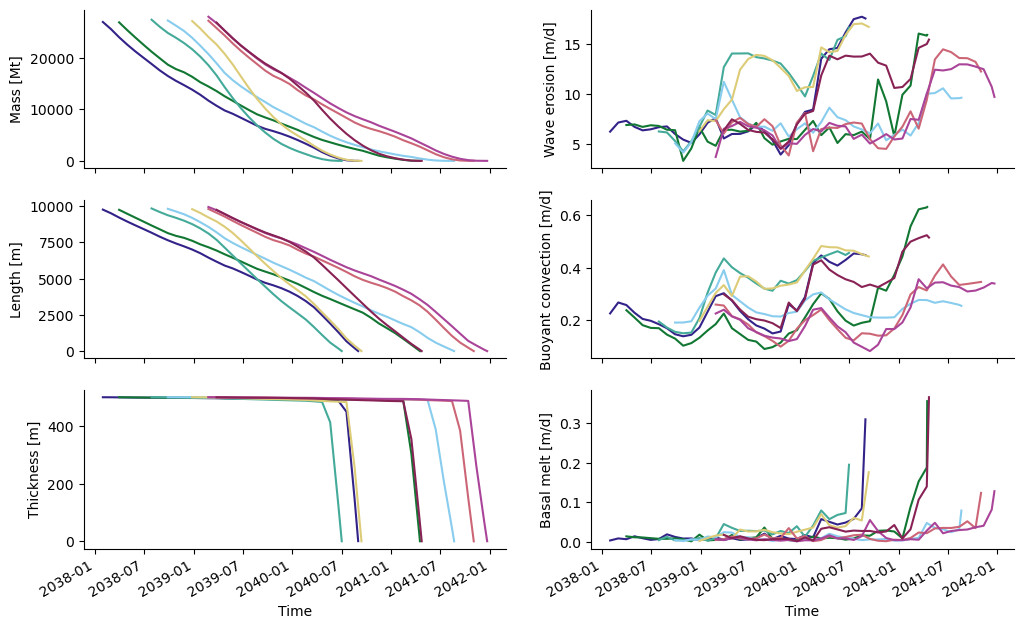

In [31]:
fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(3, 2, wspace=0.2, width_ratios=(1, 1))
axs = gs.subplots()

print(f'Start plotting...')
axs[0,0].set_prop_cycle(custom_cycler)
axs[0,0].plot(part['time'].T, part['M'].T*1e-9)
axs[0,0].set_ylabel('Mass [Mt]')
axs[0,0].set_xticklabels([])
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

axs[1,0].set_prop_cycle(custom_cycler)
axs[1,0].plot(part['time'].T, L.T)
axs[1,0].set_ylabel('Length [m]')
axs[1,0].set_xticklabels([])
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)

axs[2,0].set_prop_cycle(custom_cycler)
axs[2,0].plot(part['time'].T, T.T)
axs[2,0].set_ylabel('Thickness [m]')
axs[2,0].set_xlabel('Time')
for label in axs[2,0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)

print(f'   second column...')


axs[0,1].set_prop_cycle(custom_cycler)
axs[0,1].plot(part['time'].T, part['Mer'].T*86400.)
axs[0,1].set_ylabel('Wave erosion [m/d]')
axs[0,1].set_xticklabels([])
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)

axs[1,1].set_prop_cycle(custom_cycler)
axs[1,1].plot(part['time'].T, part['Mvr'].T*86400.)
axs[1,1].set_ylabel('Buoyant convection [m/d]')
axs[1,1].set_xticklabels([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

axs[2,1].set_prop_cycle(custom_cycler)
axs[2,1].plot(part['time'].T, part['Mbr'].T*86400.)
axs[2,1].set_ylabel('Basal melt [m/d]')
axs[2,1].set_xlabel('Time')
for label in axs[2,1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)


print(f'   saving...')
plt.savefig(f'figures/Thesis/SF_meltrates.pdf', bbox_inches='tight', dpi=600)

plt.show()

C4 standard

In [122]:
part, T, L = select_traj(C4g)
name = 'C4g'
label = 'C4 icebergs'

/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


Start plotting...


/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/neth

   second column...


/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/nethome/5867800/.conda/envs/py3_parcels/lib/python3.8/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/neth

   saving...


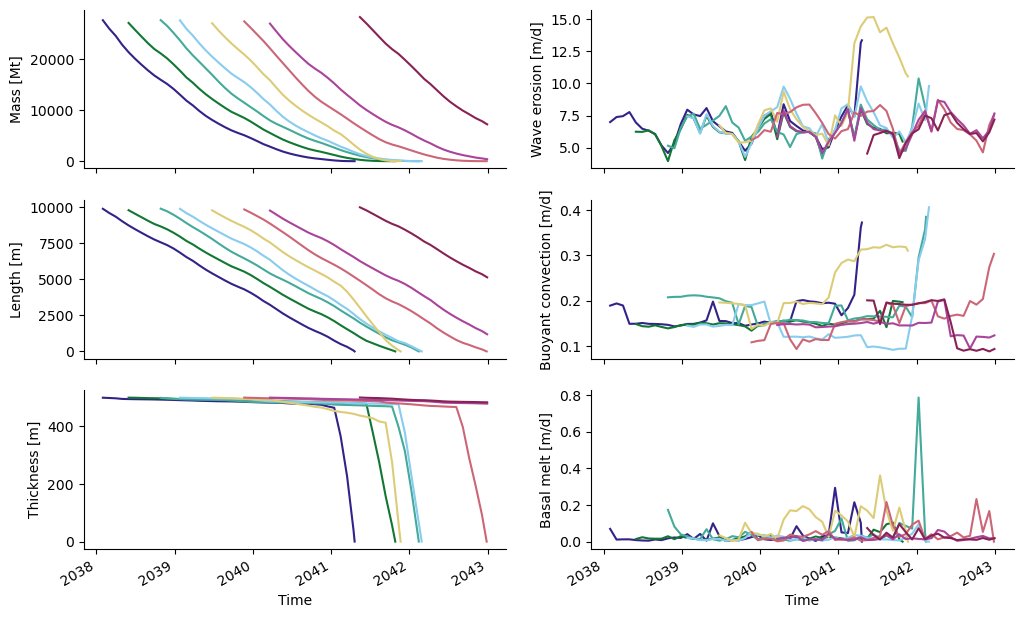

In [123]:
fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(3, 2, wspace=0.2, width_ratios=(1, 1))
axs = gs.subplots()

print(f'Start plotting...')
axs[0,0].set_prop_cycle(custom_cycler)
axs[0,0].plot(part['time'].T, part['M'].T*1e-9)
axs[0,0].set_ylabel('Mass [Mt]')
axs[0,0].set_xticklabels([])
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)

axs[1,0].set_prop_cycle(custom_cycler)
axs[1,0].plot(part['time'].T, L.T)
axs[1,0].set_ylabel('Length [m]')
axs[1,0].set_xticklabels([])
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)

axs[2,0].set_prop_cycle(custom_cycler)
axs[2,0].plot(part['time'].T, T.T)
axs[2,0].set_ylabel('Thickness [m]')
axs[2,0].set_xlabel('Time')
for label in axs[2,0].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)

print(f'   second column...')


axs[0,1].set_prop_cycle(custom_cycler)
axs[0,1].plot(part['time'].T, part['Mer'].T*86400.)
axs[0,1].set_ylabel('Wave erosion [m/d]')
axs[0,1].set_xticklabels([])
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)

axs[1,1].set_prop_cycle(custom_cycler)
axs[1,1].plot(part['time'].T, part['Mvr'].T*86400.)
axs[1,1].set_ylabel('Buoyant convection [m/d]')
axs[1,1].set_xticklabels([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

axs[2,1].set_prop_cycle(custom_cycler)
axs[2,1].plot(part['time'].T, part['Mbr'].T*86400.)
axs[2,1].set_ylabel('Basal melt [m/d]')
axs[2,1].set_xlabel('Time')
for label in axs[2,1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)


print(f'   saving...')
plt.savefig(f'figures/Thesis/C4g_meltrates.pdf', bbox_inches='tight', dpi=600)

plt.show()

## Backwards

In [6]:
### Thesis figures
C1b = xr.open_zarr('/nethome/5867800/active/25p_5y_int_30d_1hdtar_C1_bw.zarr')    # no grounding, C1 (10)
C2b = xr.open_zarr('/nethome/5867800/active/25p_5y_int_30d_1hdtar_C2_bw.zarr')    # no grounding, C2 (100)
C3b = xr.open_zarr('/nethome/5867800/active/25p_5y_int_30d_1hdtar_C3_bw.zarr')    # no grounding, C3 (1000)
SB = xr.open_zarr('/nethome/5867800/active/25p_5y_surf_30d_1hdtar_C1.zarr')       # surface, C1 (10)

### Supplements
PB = xr.open_zarr('/nethome/5867800/passive/25p_5y_30d_1hdtar_bw.zarr')           # passive
C1s = xr.open_zarr('/nethome/5867800/active/25p_5y_int_30d_1hdtar_C1s.zarr')      # no grounding, C1 changed loc (10) 
C1a = xr.open_zarr('/nethome/5867800/active/25p_5y_int_30d_1hdtar_C1a.zarr')      # no grounding, C1 adapted melt (10)  

In [7]:
data = [C1b, C2b, C3b, SB]
names = ['C1', 'C2', 'C3', 'SB']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', 'C1 icebergs - surface only']

data_sup = [PB, C1s, C1a]
names_sup = ['PB', 'C1s', 'C1a']
labels_sup = ['Passive particles', 'C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Minimum values mass and thickness - main simulations

In [61]:
for dat, name in zip(data, names):
    if name != '-':
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'Start calculating minimum {name}...')
        mmin = np.nanmin(masked_dat['M'].values)/1e9
        tmin = np.nanmin(masked_dat['z'].values*(1027.5/850.))
        print(f"   {mmin}, {tmin}")

Start calculating minimum C1...
   5.563308032, 14.187088966369629
Start calculating minimum C2...
   8.740345856, 21.157405853271484
Start calculating minimum C3...
   373.804498944, 203.8274383544922
Start calculating minimum SB...
   5.226497536, 13.578523635864258


Minimum values mass and thickness - extra simulations

In [62]:
for dat, name in zip(data_sup, names_sup):
    if name != '-':
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'Start calculating minimum {name}...')
        mmin = np.nanmin(masked_dat['M'].values)/1e9
        tmin = np.nanmin(masked_dat['z'].values*(1027.5/850.))
        print(f"   {mmin}, {tmin}")

Start calculating minimum C1s...
   4.763643392, 13.705606460571289
Start calculating minimum C1a...
   5.563308032, 14.187088966369629


Number of data points per region

Appendix C - Table 2

In [33]:
for dat, name in zip(data, names):
    print(f'For {name}:')
    print(f'   {np.unique(dat.reg, return_counts=True)}')

For C1:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1431312, 1324030,   59079,    5043,    3269,    2494,     350,
            65,       8]))
For C2:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1434115, 1315696,   62100,    5642,    4332,    3386,     344,
            25,      10]))
For C3:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1416992, 1176060,  109941,   24511,   43157,   32756,   19348,
          2638,     247]))
For SB:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00, 

Table S3.2

In [34]:
for dat, name in zip(data_sup, names_sup):
    print(f'For {name}:')
    print(f'   {np.unique(dat.reg, return_counts=True)}')

For PB:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1421128, 1343097,   54579,    3792,    1554,    1294,     164,
            31,      11]))
For C1s:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1424132, 1304246,   84398,    5869,    3540,    3064,     340,
            59,       2]))
For C1a:
   (array([-2.14748365e+09,  0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  4.00000000e+00,  5.00000000e+00,  6.00000000e+00,
        7.00000000e+00]), array([1433293, 1322055,   59078,    5043,    3269,    2494,     350,
            65,       3]))


Prepare data

In [35]:
i=0
for dat, name in zip(data, names):
    print(f'Start preparing {name}...')
    
    ### Select coastal regions
    reg_bool = dat['reg']>=2

    ### Find the last index of 'True' and replace rows with only 'False' with nan
    first_true_idx = np.argmax(np.fliplr(reg_bool)==True, axis=1)
    last_true_idx = (np.fliplr(reg_bool).shape[1] - first_true_idx - 1).astype(np.float64)
    last_true_idx[np.all(reg_bool == False, axis=1)] = np.nan
    
    c = last_true_idx+1.
    
    ### Study temporal evolution till last point in coastal region
    ## Define arrays
    evom = np.ones((len(c),len(dat['obs']))) * np.nan
    evod = np.ones((len(c),len(dat['obs']))) * np.nan
    evor = np.ones((len(c),len(dat['obs']))) * np.nan
    
    ### Create a boolean mask to select relevant values
    print(f'   start masking...')
    mask = np.arange(evom.shape[1]) < c[:, None]
    
    ### Assign values to the new arrays using boolean indexing
    evom[mask] = (dat['M'].values)[mask] # [kg]
    evod[mask] = (dat['z'].values)[mask]
    evor[mask] = (dat['reg'].values)[mask]
    
    ### Calculate thickness, area, length
    evot = evod*(1027.5/850.)
    
    ### Create dataframe
    print(f'   start dataframe...')
    seldata = pd.DataFrame(data={'mass': evom.flatten()*(1e-9), # [Mt]
                                 'thickness': evot.flatten(),
                                 'region': evor.flatten()})
    
    if i==0:
        prep0 = seldata
    elif i==1:
        prep1 = seldata
    elif i==2:
        prep2 = seldata
    elif i==3:
        prep3 = seldata
    
    i +=1
print('done')

Start preparing C1...
   start masking...
   start dataframe...
Start preparing C2...
   start masking...
   start dataframe...
Start preparing C3...
   start masking...
   start dataframe...
Start preparing SB...
   start masking...
   start dataframe...
done


In [36]:
preps = [prep0, prep1, prep2, 0, prep3, 0]
names = ['C1', 'C2', 'C3', '-', 'C2s', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

In [8]:
i=0
for dat, name in zip(data_sup[1:], names_sup[1:]):
    print(f'Start preparing {name}...')

    ### Select coastal regions
    reg_bool = dat['reg']>=2

    ### Find the last index of 'True' and replace rows with only 'False' with nan
    first_true_idx = np.argmax(np.fliplr(reg_bool)==True, axis=1)
    last_true_idx = (np.fliplr(reg_bool).shape[1] - first_true_idx - 1).astype(np.float64)
    last_true_idx[np.all(reg_bool == False, axis=1)] = np.nan

    c = last_true_idx+1.

    ### Study temporal evolution till last point in coastal region
    ## Define arrays
    evom = np.ones((len(c),len(dat['obs']))) * np.nan
    evod = np.ones((len(c),len(dat['obs']))) * np.nan
    evor = np.ones((len(c),len(dat['obs']))) * np.nan

    ### Create a boolean mask to select relevant values
    print(f'   start masking...')
    mask = np.arange(evom.shape[1]) < c[:, None]

    ### Assign values to the new arrays using boolean indexing
    evom[mask] = (dat['M'].values)[mask] # [kg]
    evod[mask] = (dat['z'].values)[mask]
    evor[mask] = (dat['reg'].values)[mask]

    ### Calculate thickness, area, length
    evot = evod*(1027.5/850.)

    ### Create dataframe
    print(f'   start dataframe...')
    seldata = pd.DataFrame(data={'mass': evom.flatten()*(1e-9), # [Mt]
                                 'thickness': evot.flatten(),
                                 'region': evor.flatten()})
    
    if i==0:
        prep4 = seldata
    elif i==1:
        prep5 = seldata
    
    i +=1
print('done')

Start preparing C1s...
   start masking...
   start dataframe...
Start preparing C1a...
   start masking...
   start dataframe...
done


In [9]:
preps_sup = [prep4, prep5]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

In [10]:
### Define colourscheme (same colours as Carter et al. (2014))
cols = ['#d2d3d4','#ada4ce','#e5a787','#cc393c','#d578aa','#d6c7d0']

In [11]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Region')

### Mass

#### Per region:

Figure 3.4a

Load C1:
   plotting mass...
Load C2:
   plotting mass...
Load C3:
   plotting mass...
Load C2s:
   plotting mass...
Saving figures...


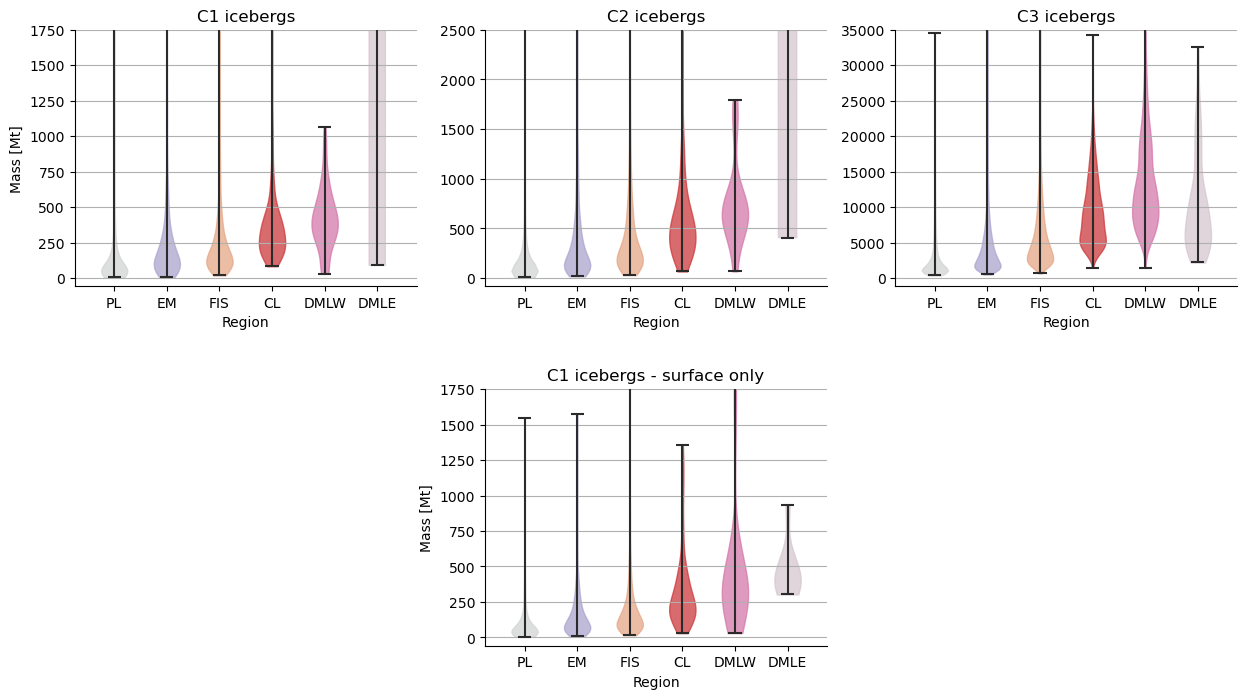

In [41]:
### Study mass distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]')
            
        if i==2:
            ax.set_ylim(-35000/30., 35000)
        elif i==1:
            ax.set_ylim(-2500/30., 2500)
        else:
            ax.set_ylim(-1750/30, 1750)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Mregl.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Mregl.pdf', bbox_inches='tight', dpi=600)
plt.show()

Appendix D - Figure 2a

Load C1:
   plotting mass...
Load C2:
   plotting mass...
Load C3:
   plotting mass...
Load C2s:
   plotting mass...
Saving figures...


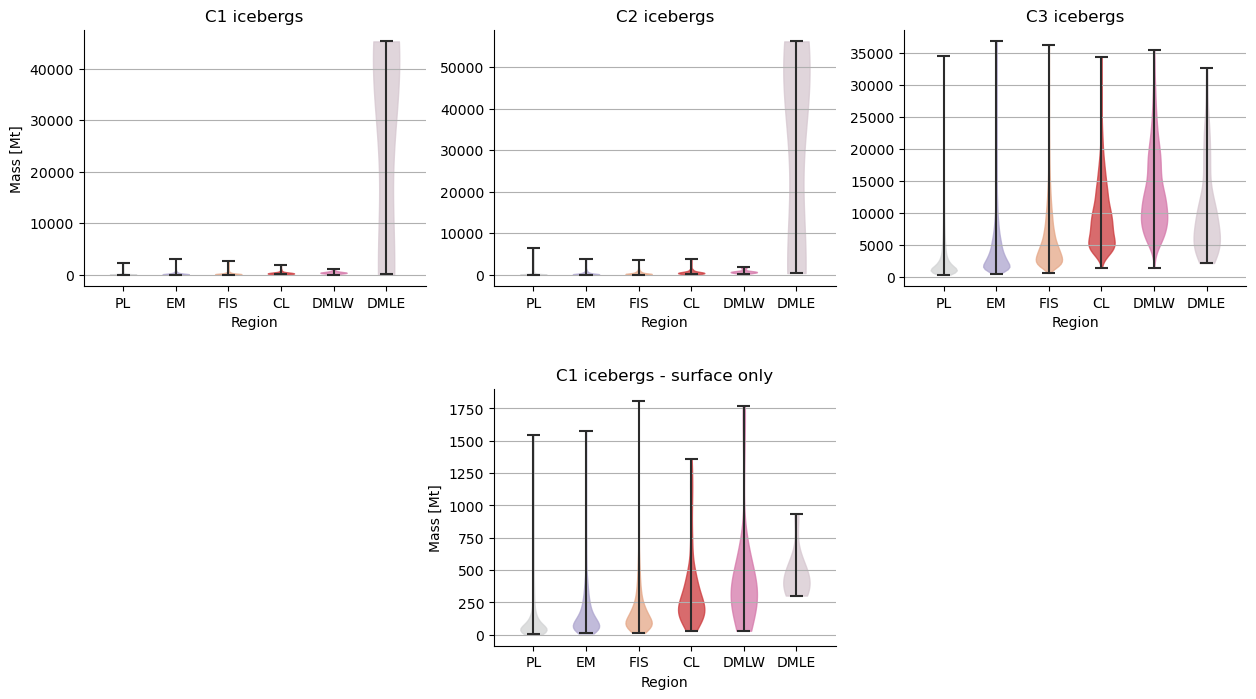

In [42]:
### Study mass distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]')

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Mregfulll.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Mregfulll.pdf', bbox_inches='tight', dpi=600)
plt.show()

Minimum values

Load C1:
   plotting mass...
Load C2:
   plotting mass...
Load C3:
   plotting mass...
Load C2s:
   plotting mass...


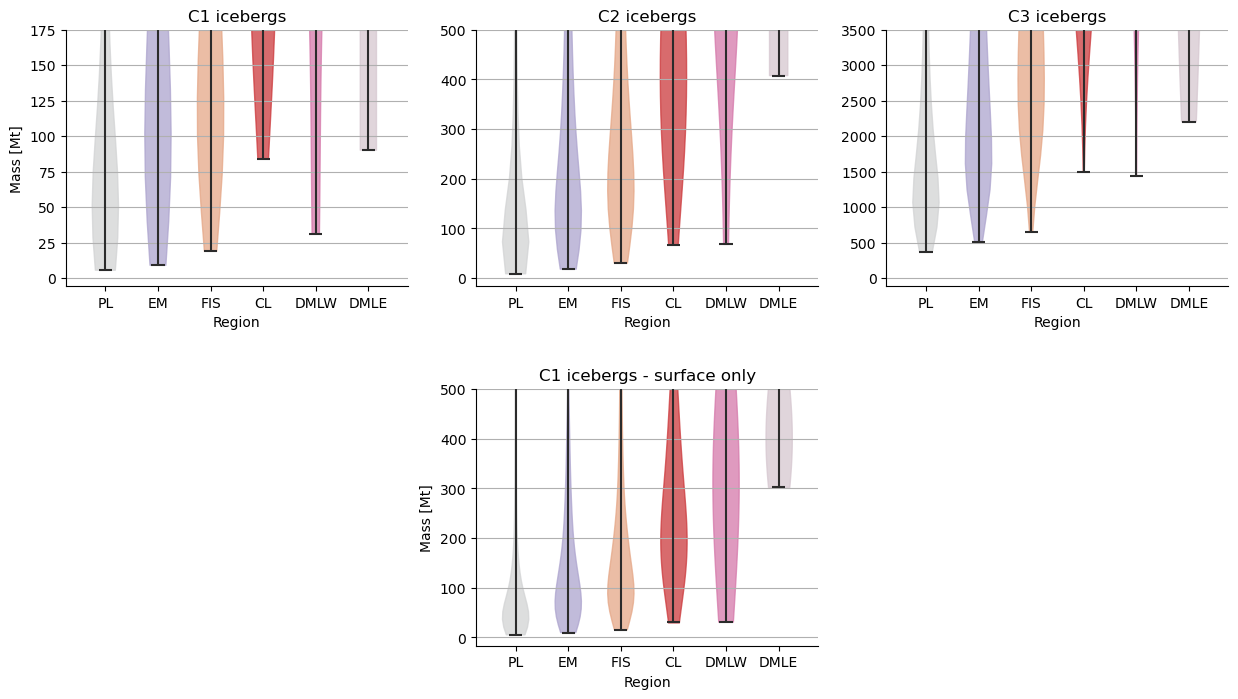

In [43]:
### Study mass distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]')
            
        if i==2:
            ax.set_ylim(-3500/30., 3500)
        elif i==1 or i==4:
            ax.set_ylim(-500/30., 500)
        else:
            ax.set_ylim(-175/30, 175)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

plt.show()

Load C1:
   plotting mass...
Load C2:
   plotting mass...
Load C3:
   plotting mass...
Load C2s:
   plotting mass...


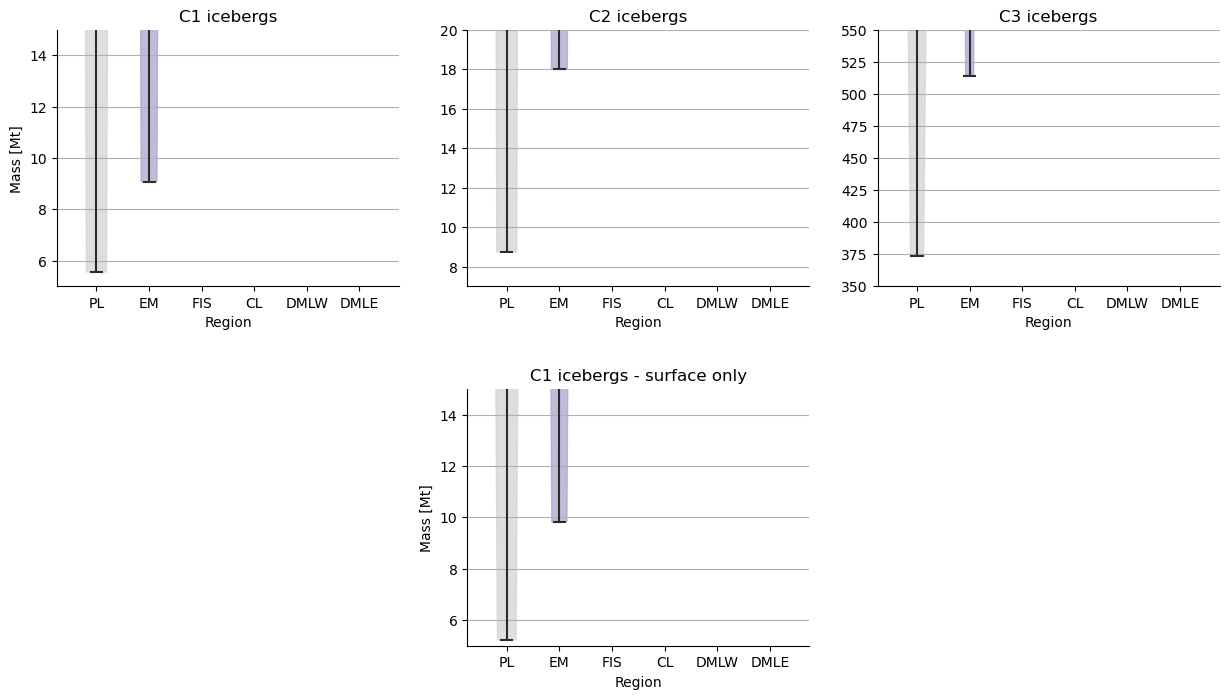

In [44]:
### Study mass distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Mass [Mt]')
            
        if i==2:
            ax.set_ylim(350, 550)
        elif i==1:
            ax.set_ylim(7, 20)
        else:
            ax.set_ylim(5, 15)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

plt.show()

Figure S3.4a

Load C1s:
   plotting mass...
Load C1a:
   plotting mass...
Saving figures...


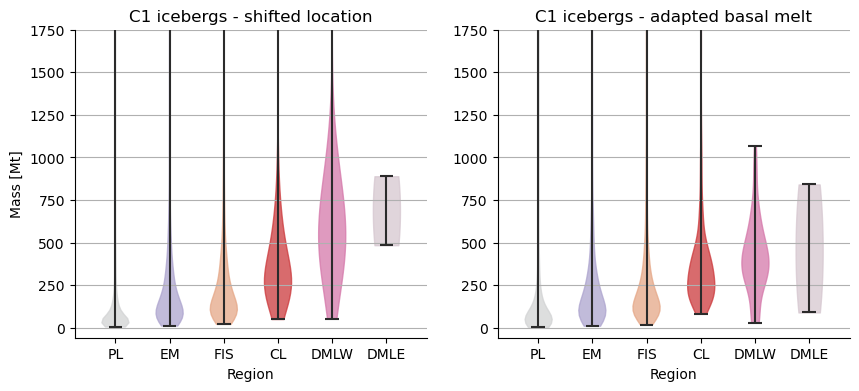

In [45]:
### Study mass distribution spatially
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))   # fill top row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0:
            ax.set_ylabel('Mass [Mt]')
            
        ax.set_ylim(-1750/30, 1750)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Mregl-sup.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Mregl-sup.pdf', bbox_inches='tight', dpi=600)
plt.show()

Minimum values

Load C1s:
   plotting mass...
Load C1a:
   plotting mass...


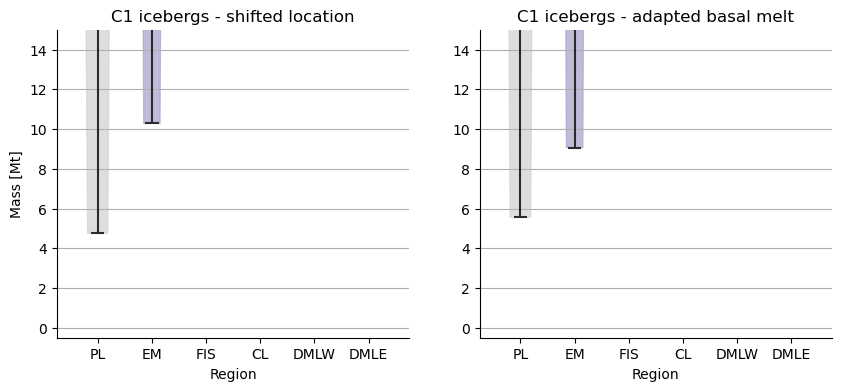

In [12]:
### Study mass distribution spatially
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))   # fill top row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting mass...')

        ### Violinplots
        ## Mass
        if (len(prep[prep['region'] == 7]['mass'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     [7e13,7e13]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['mass'].dropna().values,
                                     prep[prep['region'] == 3]['mass'].dropna().values,
                                     prep[prep['region'] == 4]['mass'].dropna().values,
                                     prep[prep['region'] == 5]['mass'].dropna().values,
                                     prep[prep['region'] == 6]['mass'].dropna().values,
                                     prep[prep['region'] == 7]['mass'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0:
            ax.set_ylabel('Mass [Mt]')
            
        ax.set_ylim(-15/30, 15)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

plt.show()

#### Spatially:

Figure 3.3a

In [8]:
data = [C1b, C2b, C3b, 0, SB, 0]
names = ['C1', 'C2', 'C3', '-', 'SB', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

Start preparing C1...
   and plot...
Start preparing C2...
   and plot...
Start preparing C3...
   and plot...
Start preparing SB...
   and plot...
Saving figures...


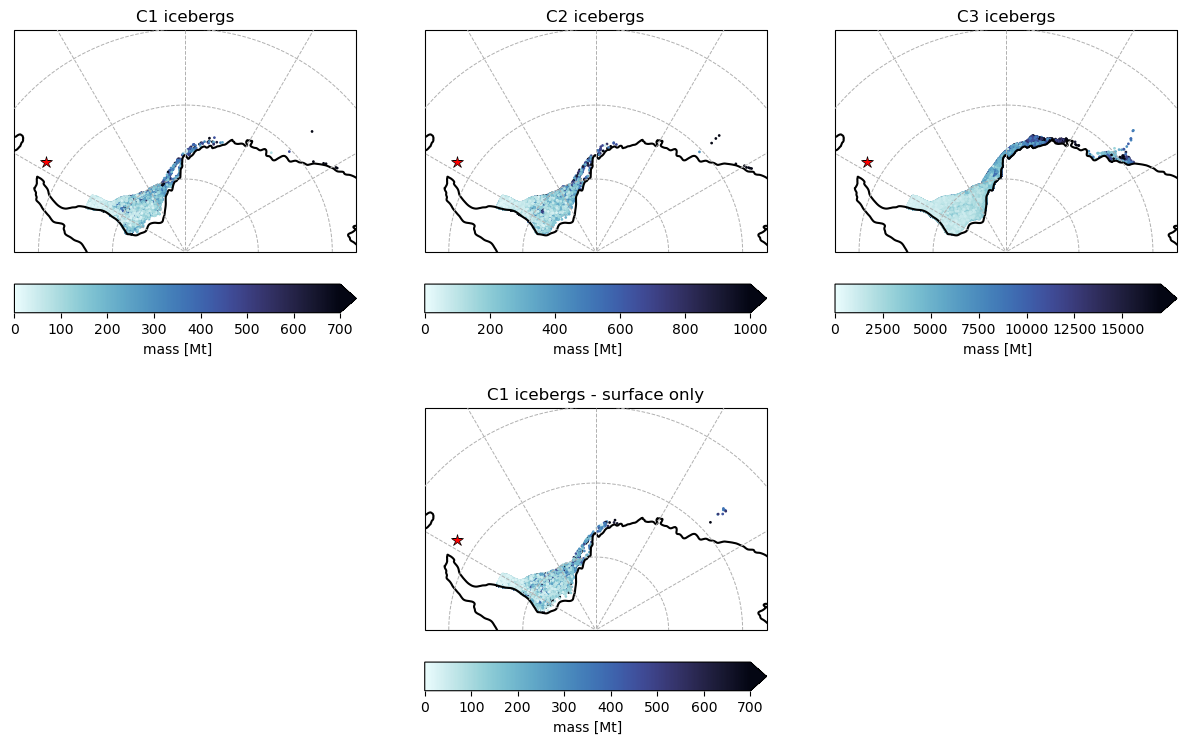

In [68]:
### Study mass distribution spatially
fig = plt.figure(figsize=(15,9))

gs = GridSpec(2, 1, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 2 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 2 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1], gs0[1,2], gs1[1,0], gs1[1,1], gs1[1,2])]

# Loop over all of the models
for dat, name, label, ax, c_ax in zip(data, names, labels, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        ## Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        ## ODP, contour
        ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(),
                zorder=2) # Site 696
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)
        
        ## Data
        if name=='C2':
            normalize = colors.Normalize(vmin=0, vmax=1000.)
        elif name=='C3':
            normalize = colors.Normalize(vmin=0, vmax=17000.)
        else:
            normalize = colors.Normalize(vmin=0, vmax=700.)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=masked_dat['M'].values/1e9, transform=ccrs.PlateCarree(),
                        linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, zorder=0, norm=normalize)
        plt.colorbar(cf, cax=c_ax, orientation='horizontal', label=r'mass [Mt]', extend='max') # 1 Mt = 10E8 kg 

        ## Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])

        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        ax.set_title(f'{str(label)}')
    else:
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Mmap.png', bbox_inches='tight', dpi=600)
# fig.savefig(f'figures/Thesis/Min-Mmap.pdf', bbox_inches='tight', dpi=300)
plt.show()

Figure S3.3a

In [49]:
data_sup = [C1s, C1a]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Start preparing C1s...
   and plot...
Start preparing C1a...
   and plot...
Saving figures...


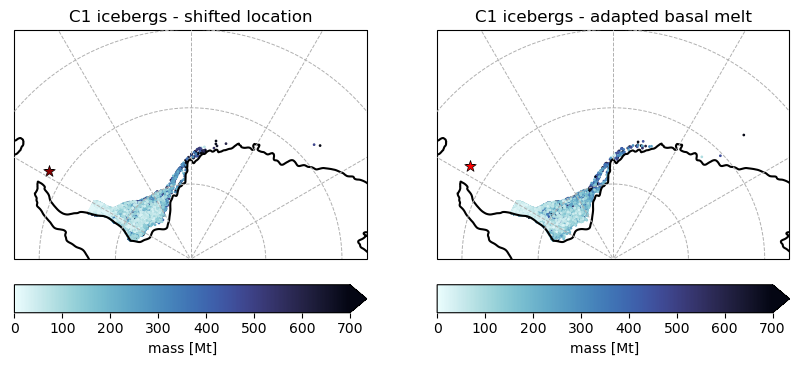

In [69]:
### Study mass distribution spatially
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)
gs0 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1))

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1])]

# Loop over all of the models
for dat, name, label, ax, c_ax in zip(data_sup, names_sup, labels_sup, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        ## Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        ## ODP, contour
        if name == 'C1s':
            ax.scatter(x696-1, y696-0.5, color='darkred', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        else:
            ax.scatter(x696, y696, color='r', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        # ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(),
                # zorder=2) # Site 696
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(),
                   colors='k', zorder=1)
        ax.scatter(1, -78.38, transform=ccrs.PlateCarree(), color='white', zorder=2, s=15)
        
        ## Data
        normalize = colors.Normalize(vmin=0, vmax=700.)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=masked_dat['M'].values/1e9, transform=ccrs.PlateCarree(),
                        linewidth=.8, s=1.3, cmap=cmo.cm.ice_r, zorder=0, norm=normalize)
        plt.colorbar(cf, cax=c_ax, orientation='horizontal', label=r'mass [Mt]', extend='max') # 1 Mt = 10E8 kg 

        ## Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])

        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        ax.set_title(f'{str(label)}')
    else:
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Mmap-sup.png', bbox_inches='tight', dpi=600)
plt.show()

### Thickness

#### Per region:

Figure 3.4b

Load C1:
   plotting thickness...
Load C2:
   plotting thickness...
Load C3:
   plotting thickness...
Load C2s:
   plotting thickness...
Saving figures...


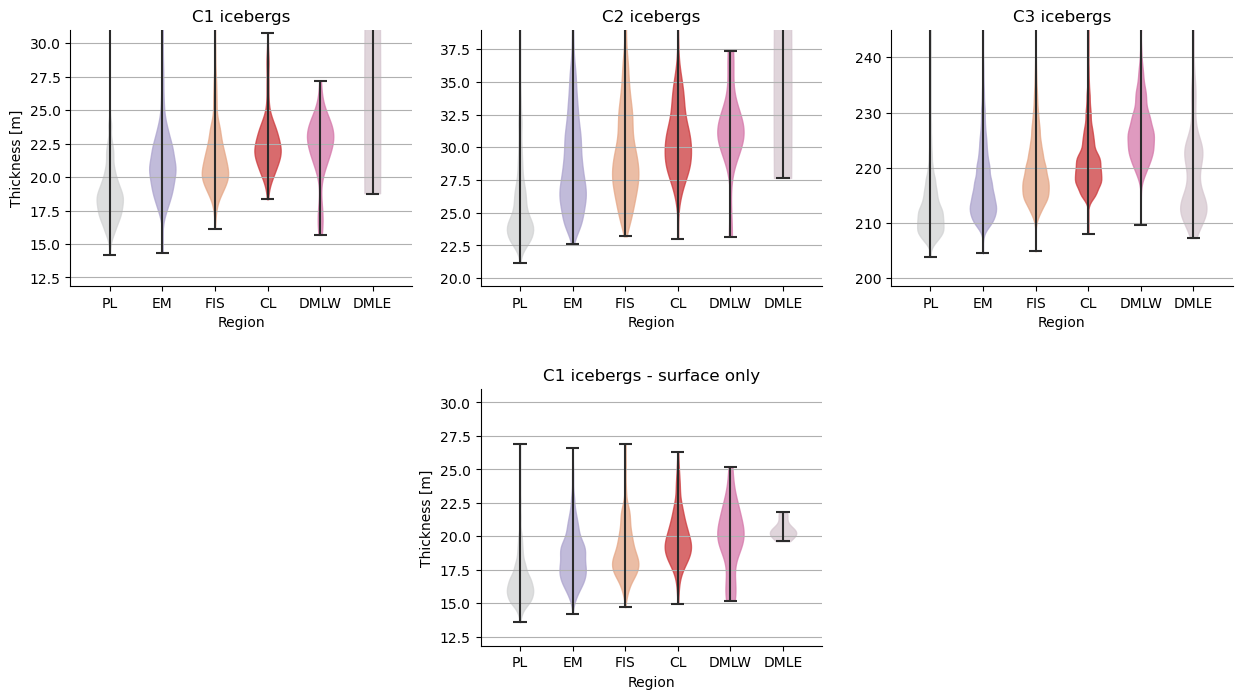

In [46]:
### Study thickness distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting thickness...')

        ### Violinplots
        ## Thickness
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Thickness [m]')
        
        if i==2:
            ax.set_ylim(200-(45/30),245)
        elif i==1:
            ax.set_ylim(20-(19/30),39)
        else:
            ax.set_ylim(12-(5/30), 31)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Tregl.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Tregl.pdf', bbox_inches='tight', dpi=600)
plt.show()

Appendix D - Figure 2b

Load C1:
   plotting thickness...
Load C2:
   plotting thickness...
Load C3:
   plotting thickness...
Load C2s:
   plotting thickness...
Saving figures...


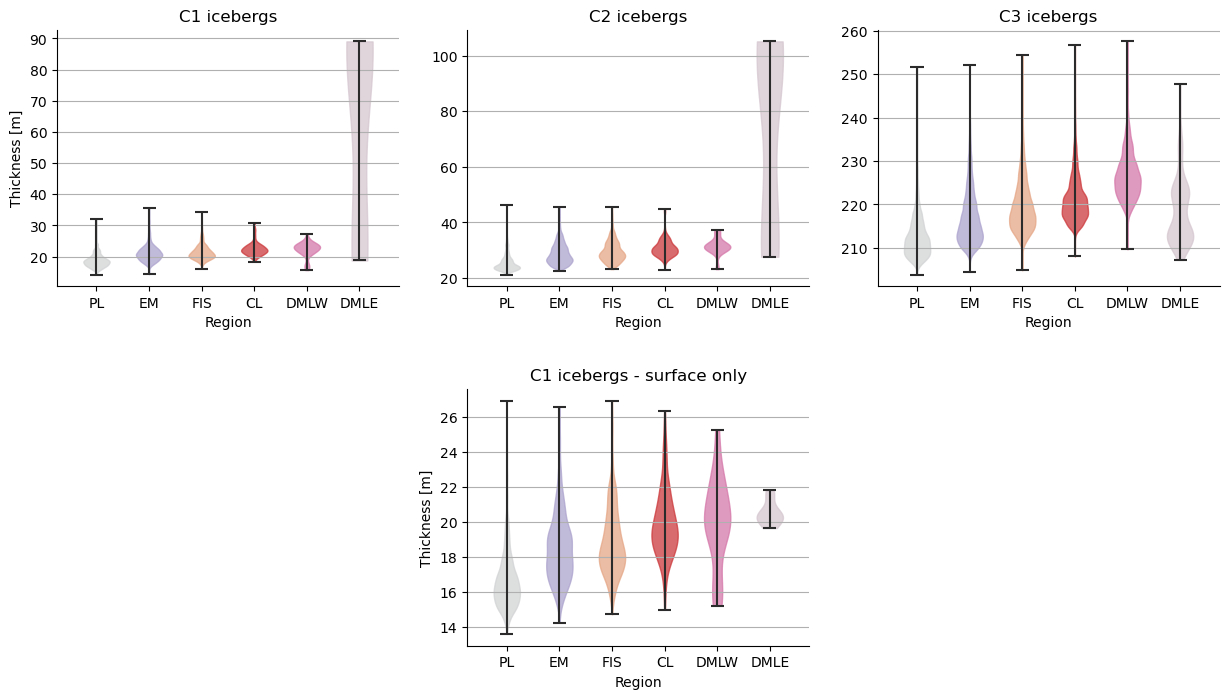

In [47]:
### Study thickness distribution spatially
fig = plt.figure(figsize=(15,8))

gs = GridSpec(2, 1, hspace=0.4, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 1 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps, names, labels, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting thickness...')

        ### Violinplots
        ## Thickness
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0 or i==4:
            ax.set_ylabel('Thickness [m]')

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Tregfulll.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Tregfulll.pdf', bbox_inches='tight', dpi=600)
plt.show()

Figure S3.4b

Load C1s:
   plotting thickness...
Load C1a:
   plotting thickness...
Saving figures...


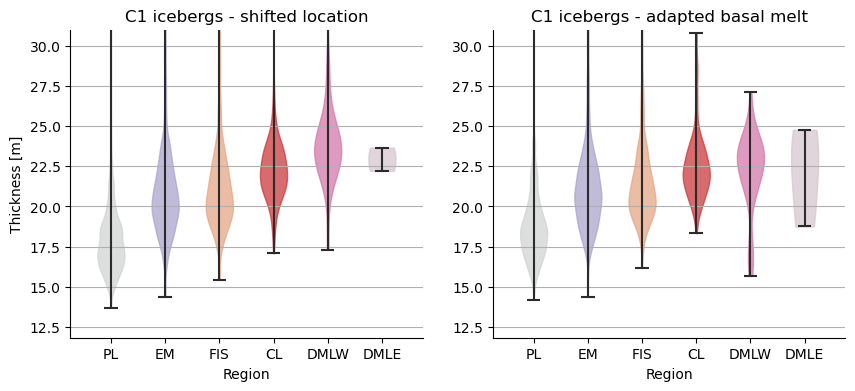

In [48]:
### Study thickness distribution spatially
fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 1)   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], wspace=0.2, width_ratios=(1, 1))   # fill top row: 1 rows, 3 columns

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g) for g in (gs0[0,0], gs0[0,1])]

labs = ['PL', 'EM', 'FIS', 'CL', 'DMLW', 'DMLE']

i = 0
# Loop over all of the models
for prep, name, label, ax in zip(preps_sup, names_sup, labels_sup, axes):
    if type(prep)!=int:
        print(f'Load {name}:')
        print(f'   plotting thickness...')

        ### Violinplots
        ## Thickness
        if (len(prep[prep['region'] == 7]['thickness'].values)) == 0:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     [400,400]] ) # !!! because 7 is empty#
        else:
            plts = ax.violinplot(dataset = [prep[prep['region'] == 2]['thickness'].dropna().values,
                                     prep[prep['region'] == 3]['thickness'].dropna().values,
                                     prep[prep['region'] == 4]['thickness'].dropna().values,
                                     prep[prep['region'] == 5]['thickness'].dropna().values,
                                     prep[prep['region'] == 6]['thickness'].dropna().values,
                                     prep[prep['region'] == 7]['thickness'].dropna().values] )
        
        for bd, col in zip(plts['bodies'], cols):
            bd.set_facecolor(col)
            bd.set_alpha(.75)
            bd.set_edgecolor(col)
        
        plts['cbars'].set_color('#2b2b2b')
        plts['cmins'].set_color('#2b2b2b')
        plts['cmaxes'].set_color('#2b2b2b')
        
        set_axis_style(ax, labs)

        ax.set_title(f'{label}')
        ax.yaxis.grid(True)
        ax.set_xlabel('Region')
        if i==0:
            ax.set_ylabel('Thickness [m]')
        
        ax.set_ylim(12-(5/30), 31)

        ### Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)

    else:
        fig.delaxes(ax)
    
    i += 1

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Tregl-sup.png', bbox_inches='tight', dpi=600)
fig.savefig(f'figures/Thesis/Min-Tregl-sup.pdf', bbox_inches='tight', dpi=600)
plt.show()

#### Spatially:

Figure 3.3b

In [56]:
data = [C1b, C2b, C3b, 0, SB, 0]
names = ['C1', 'C2', 'C3', '-', 'SB', '-']
labels = ['C1 icebergs', 'C2 icebergs', 'C3 icebergs', '-', 'C1 icebergs - surface only', '-']

Start preparing C1...
   and plot...
Start preparing C2...
   and plot...
Start preparing C3...
   and plot...
Start preparing SB...
   and plot...
Saving figures...


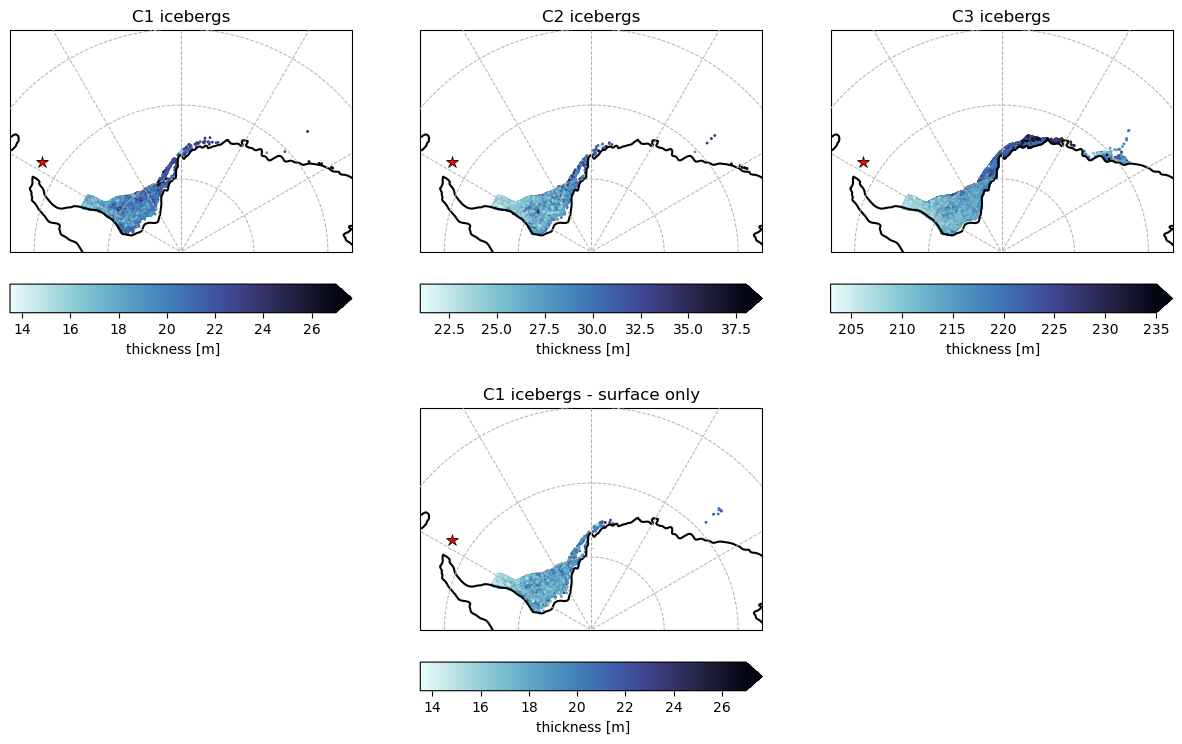

In [63]:
### Study thickness distribution spatially
fig = plt.figure(figsize=(15,9))

gs = GridSpec(2, 1, height_ratios=[1,1])   # one overall figure: 2 row, 1 column
gs0 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1, 1))   # fill top row: 2 rows, 3 columns
gs1 = GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[1], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1, 1))   # fill bottom row: 2 rows, 3 columns


# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1], gs0[0,2], gs1[0,0], gs1[0,1], gs1[0,2])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1], gs0[1,2], gs1[1,0], gs1[1,1], gs1[1,2])]

# Loop over all of the models
for dat, name, label, ax, c_ax in zip(data, names, labels, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        ### Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        evot = (masked_dat['z'].values*(1027.5/850.))
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        ## ODP, contour
        ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=2) # Site 696
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=1)
        ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=2, s=12)
        
        ## Data
        if name=='C3':
            normalize = colors.Normalize(vmin=203, vmax=235)
        elif name=='C2':
            normalize = colors.Normalize(vmin=21, vmax=38)
        else:
            normalize = colors.Normalize(vmin=13.5, vmax=27)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=evot, transform=ccrs.PlateCarree(),
                        linewidth=.8, s=1.5, cmap=cmo.cm.ice_r, norm=normalize, zorder=0)
        plt.colorbar(cf, cax=c_ax, orientation='horizontal', label=r'thickness [m]', extend='max') 

        ## Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])

        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        ax.set_title(f'{str(label)}')
    else:
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Tmap.png', bbox_inches='tight', dpi=600)
# fig.savefig(f'figures/Thesis/Min-Tmap.pdf', bbox_inches='tight', dpi=600)
plt.show()

Figure S3.3b

In [51]:
data_sup = [C1s, C1a]
names_sup = ['C1s', 'C1a']
labels_sup = ['C1 icebergs - shifted location', 'C1 icebergs - adapted basal melt']

Start preparing C1s...
   and plot...
Start preparing C1a...
   and plot...
Saving figures...


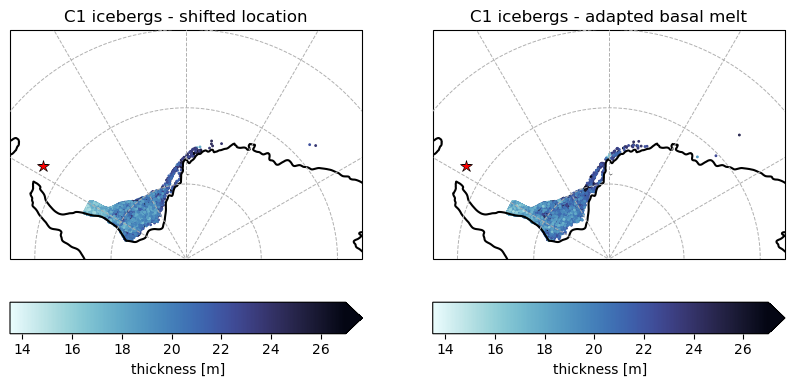

In [64]:
### Study thickness distribution spatially
fig = plt.figure(figsize=(10,4.5))

gs = GridSpec(1, 1)
gs0 = GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], hspace=0.0, height_ratios=(1, 0.1), wspace=0.2, width_ratios=(1, 1))

# initialize the cartopy and colorbar axes
axes = [fig.add_subplot(g, projection=ccrs.SouthPolarStereo()) for g in (gs0[0,0], gs0[0,1])]
cb_axes = [fig.add_subplot(g) for g in (gs0[1,0], gs0[1,1])]

# Loop over all of the models
for dat, name, label, ax, c_ax in zip(data_sup, names_sup, labels_sup, axes, cb_axes):
    if type(dat)!=int:
        print(f'Start preparing {name}...')

        ### Mask regions
        masked_dat = dat.where(dat['reg']>=2, drop=False)
        evot = (masked_dat['z'].values*(1027.5/850.))
        print(f'   and plot...')

        ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

        ## ODP, contour
        if name == 'C1s':
            ax.scatter(x696-1, y696-0.5, color='darkred', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        else:
            ax.scatter(x696, y696, color='r', marker='*', s=75, edgecolor='black', linewidth=.5, transform=ccrs.PlateCarree(), zorder=2)
        # ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=2) # Site 696
        ax.contour(lons[:760,850:2700], lats[:760,850:2700], bath[:760,850:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=1)
        ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=2, s=12)
        
        ## Data
        normalize = colors.Normalize(vmin=13.5, vmax=27)
        cf = ax.scatter(masked_dat['lon'].values, masked_dat['lat'].values, c=evot, transform=ccrs.PlateCarree(),
                        linewidth=.8, s=1.5, cmap=cmo.cm.ice_r, norm=normalize, zorder=0)
        plt.colorbar(cf, cax=c_ax, orientation='horizontal', label=r'thickness [m]', extend='max') 

        ## Gridlines
        # -60, -30, 0, 30, 60 W/E (only lines)
        gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
        gl0.ylocator = mticker.FixedLocator([])

        # 90, 80, 70, 60, 50 S (only lines)
        gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=3)
        gl1.xlocator = mticker.FixedLocator([])
        gl1.ylocator = mticker.FixedLocator(np.arange(-90,-49,10))

        ax.set_title(f'{str(label)}')
    else:
        fig.delaxes(ax)
        fig.delaxes(c_ax)

print(f'Saving figures...')
fig.savefig(f'figures/Thesis/Min-Tmap-sup.png', bbox_inches='tight', dpi=600)
plt.show()

## Modern

In [202]:
# Load data
day = xr.open_zarr('/nethome/5867800/modern/modern_1y_int_30d_1hdtar_C4_hourly.zarr')    # day/hour
mon = xr.open_zarr('/nethome/5867800/modern/modern_1y_int_30d_1hdtar_C4_monthly_ate.zarr')   # month + day + extrap

In [204]:
# Mask zero values
day_masked = day.where(day['M'] > 0.)
mon_masked = mon.where(mon['M'] > 0.)

In [208]:
# Group per month
mmn = mon_masked.groupby('time.month').mean()
dmn = day_masked.groupby('time.month').mean()

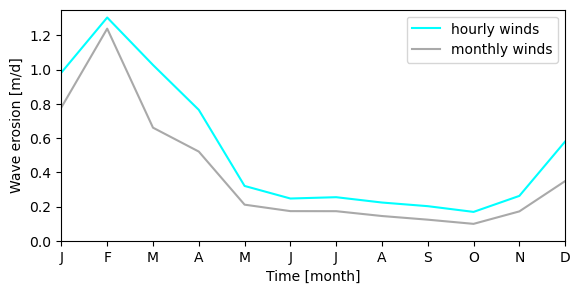

In [211]:
fig, ax = plt.subplots(1,1, figsize=(6.5,3))
ax.plot(dmn['month'].values, dmn['Mer'].values*86400., label= 'hourly winds', c='cyan')
ax.plot(mmn['month'].values, mmn['Mer'].values*86400., label='monthly winds', c='darkgrey')
ax.set_xlim(1,12)
ax.set_xlabel('Time [month]')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.set_ylim(0,1.35)
ax.set_ylabel('Wave erosion [m/d]')
ax.legend()
plt.savefig(f'figures/Thesis/Modern-Mer.png', bbox_inches='tight', dpi=600)
plt.show()

   trajectories plotted...


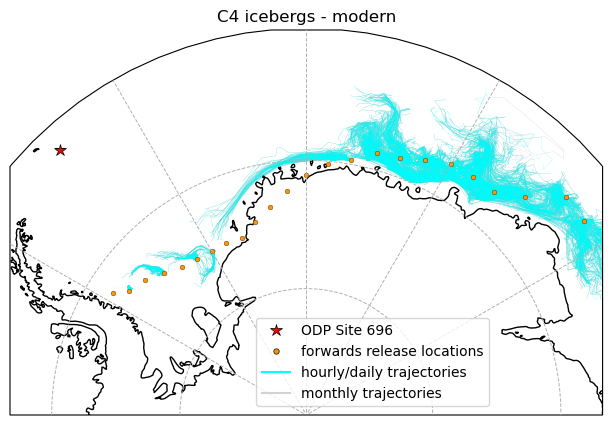

In [227]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(10,5))

### Plot small
ax.set_extent([-50, 50, -90, -60], ccrs.PlateCarree())

ylim = [-90,-60]
xlim = [-90, 90]
rect = mpath.Path([[xlim[0], ylim[0]],
                   [xlim[1], ylim[0]],
                   [xlim[1], ylim[1]],
                   [xlim[0], ylim[1]],
                   [xlim[0], ylim[0]],
                   ]).interpolated(40)
proj_to_data   = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
rect_in_target = proj_to_data.transform_path(rect)
ax.set_boundary(rect_in_target)

ax.plot(x696p, y696p, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3) # Site 696

ax.coastlines(zorder=2)

## Gridlines
# -60, -30, 0, 30, 60 W/E (only lines)
gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
gl0.xlocator = mticker.FixedLocator(np.arange(-60,61,30))
gl0.ylocator = mticker.FixedLocator([])

# 90, 80, 70, 60 S (only lines)
gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
gl1.xlocator = mticker.FixedLocator([])
gl1.ylocator = mticker.FixedLocator(np.arange(-90,-59,10))

# 50 S (only lines)
gl2 = ax.gridlines(linestyle='-', linewidth=1, color='k', draw_labels=False, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=5)
gl2.xlocator = mticker.FixedLocator([])
gl2.ylocator = mticker.FixedLocator(np.arange(-50,-49,10))

ax.plot(day['lon'].values.T, day['lat'].values.T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=1, color='cyan')
ax.plot(mon['lon'].values.T, mon['lat'].values.T, transform=ccrs.PlateCarree(), linewidth=.1, zorder=0, color='darkgrey')
print(f'   trajectories plotted...')
ax.scatter(lonsfw, latsfw+5., transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3,s=12, edgecolor='k', linewidths=0.2)

ax.set_title('C4 icebergs - modern')

handles, labels = ax.get_legend_handles_labels()
ODP = Line2D([0], [0], label='ODP Site 696', marker='*', markersize=np.sqrt(75),
             markeredgecolor='k', markerfacecolor='r', markeredgewidth=.5, linestyle='')
handles.append(ODP)
rel = Line2D([0], [0], label='forwards release locations', marker='o', markersize=np.sqrt(15),
             markeredgecolor='k', markerfacecolor='xkcd:tangerine', markeredgewidth=.5, linestyle='')
handles.append(rel)
suc = Line2D([0], [0], label='hourly/daily trajectories', color='cyan')
handles.append(suc)
oth = Line2D([0], [0], label='monthly trajectories', color='lightgrey')
handles.append(oth)
ax.legend(handles=handles, bbox_to_anchor=(0.82, .27))#, fontsize='12')

plt.savefig(f'figures/Thesis/FW-Trajectories-modern.png', bbox_inches='tight', dpi=600)
plt.show()

## Maps

In [13]:
### Define levels used for contours and bathymetry
dlevels = [-6000, -5500, -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -750, -500, -250, 0]
dnorm = BoundaryNorm(dlevels, ncolors=(len(dlevels)-1), clip=False)
blevels = range(-6000, 1, 100) # bathymetry

### Regions and release locations

Fig. 2.2a (edited in Inkscape)

In [14]:
### Load and fix data
regs = xr.open_dataset('/nethome/5867800/grid/bathymetry_regions.nc')
_, _, _, _, regg, regl = divide_longitude(regs['U_LON_2D'].values, regs['U_LAT_2D'].values, regs['region'].where(regs['region']>1.5).values)

### Define colourscheme (same colours as Carter et al. (2014))
rmap = colors.ListedColormap(['#94cff5','#d2d3d4','#ada4ce','#e5a787','#cc393c','#d578aa','#d6c7d0'])

Start plotting...
Base plotted, continue with data main figure...
Main figure finished, continue with inset...
Saving figure as svg...


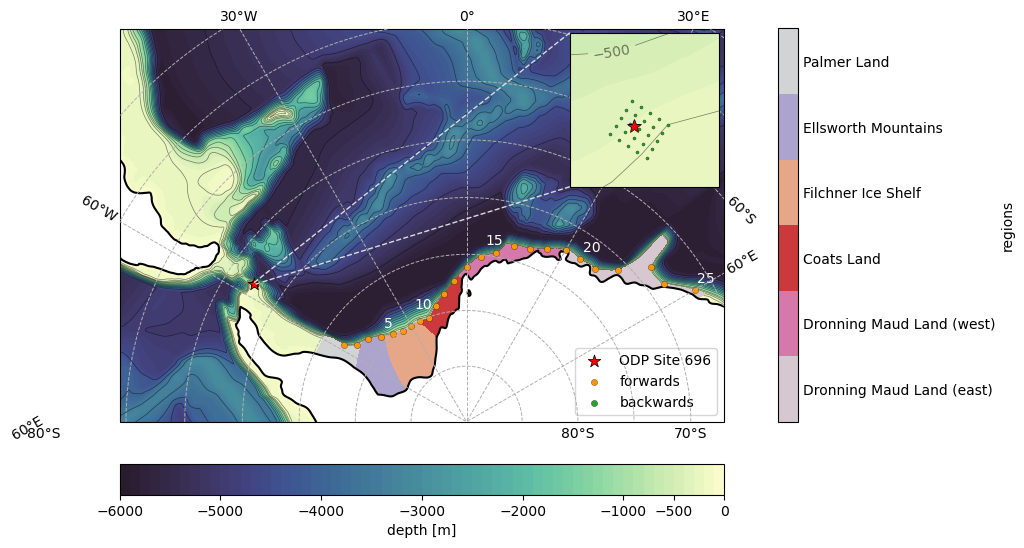

In [124]:
### General settings figure
print(f'Start plotting...')
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(10,7))
ax.set_extent([-60,40,-90,-55], ccrs.PlateCarree())

## Gridlines
# -60 W (fixed below)
gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl0.xlocator = mticker.FixedLocator(np.arange(-60,-55,60))
gl0.ylocator = mticker.FixedLocator([])
gl0.right_labels = True
gl0.bottom_labels = False
gl0.left_labels = True
gl0.top_labels = True

# 0 W/E
gl6 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl6.xlocator = mticker.FixedLocator(np.arange(0,5,60))
gl6.ylocator = mticker.FixedLocator([])
gl6.right_labels = True
gl6.bottom_labels = False
gl6.left_labels = True
gl6.top_labels = True
gl6.rotate_labels = False
gl6.ylabel_style = {'rotation':45}

# -30, 30 W/E
gl4 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl4.xlocator = mticker.FixedLocator(np.arange(-30,35,60))
gl4.ylocator = mticker.FixedLocator([])
gl4.right_labels = True
gl4.bottom_labels = False
gl4.left_labels = True
gl4.top_labels = True
gl4.rotate_labels = False
gl4.ylabel_style = {'rotation':-45}

# 85, 75, 65, 55, 50 S (only lines)
gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl1.xlocator = mticker.FixedLocator([])
gl1.ylocator = mticker.FixedLocator([-85, -75, -65, -55, -50])
gl1.right_labels = False
gl1.bottom_labels = False
gl1.left_labels = False
gl1.top_labels = False
gl1.ylabel_style = {'rotation':0}

# 80, 70 S (fixed below)
gl2 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl2.xlocator = mticker.FixedLocator([])
gl2.ylocator = mticker.FixedLocator(np.arange(-90,-69,10))
gl2.right_labels = False
gl2.bottom_labels = True
gl2.left_labels = False
gl2.top_labels = False
gl2.rotate_labels = False

# 60 S (fixed below)
gl3 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl3.xlocator = mticker.FixedLocator([])
gl3.ylocator = mticker.FixedLocator(np.arange(-60,-50,10))
gl3.right_labels = False
gl3.bottom_labels = True
gl3.left_labels = False
gl3.top_labels = False
gl3.rotate_labels = False
gl3.ylabel_style = {'rotation':-45}

# 60 E (fixed below)
gl5 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl5.xlocator = mticker.FixedLocator(np.arange(60,65,60))
gl5.ylocator = mticker.FixedLocator([])
gl5.right_labels = True
gl5.bottom_labels = False
gl5.left_labels = True
gl5.top_labels = True

print(f'Base plotted, continue with data main figure...')

### Plot main figure
## Bathymetry and coastlines
im = ax.contourf(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=blevels, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree(), zorder=0)
jm = ax.contour(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=dlevels, linewidths=0.5, alpha=0.5, colors="k", linestyles='-', transform=ccrs.PlateCarree(), zorder=1)
km = ax.contour(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)   # coastlines
# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label="depth [m]", pad=-.15, shrink=0.78, anchor=(0.0,0.0),
                    spacing='proportional', ticks=[-6000,-5000,-4000,-3000,-2000,-1000,-500,0])

# Rasterize the contour collections
for c in im.collections:
    c.set_rasterized(True)
for d in jm.collections:
    d.set_rasterized(True)
for e in km.collections:
    e.set_rasterized(True)

## ODP 696
ax.scatter(x696, y696, color='red', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(), zorder=6, label='ODP Site 696')
## Release locations
ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=5,
           label='forwards',s=20, edgecolor='k', linewidths=0.2)
ax.scatter(lonsbw, latsbw, transform=ccrs.PlateCarree(), color='tab:green', zorder=5,
           label='backwards',s=20, edgecolor='k', linewidths=0.2)
ax.text(lonsfw[3]-1.2, latsfw[3]+1, '5', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[8]-10, latsfw[8]+.4, '10', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[13]-4, latsfw[13]+.6, '15', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[18]-.5, latsfw[18]+.7, '20', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[23]-1, latsfw[23]+.5, '25', transform=ccrs.PlateCarree(), color='white')
## Release regions
im2 = ax.contourf(lonsg[:825,:], latsg[:825,:], regg[:825,:], levels=[0,1,2,3,4,5,6,7],
            cmap=rmap, transform=ccrs.PlateCarree(), zorder=2)
ax.contourf(lonsl[:825,:], latsl[:825,:], regl[:825,:], levels=[0,1,2,3,4,5,6,7],
            cmap=rmap, transform=ccrs.PlateCarree(), zorder=2)
cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', label="regions", pad=.07, shrink=0.73)
cbar2.ax.set_ylim(1, 7)
cbar2.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar2.set_ticklabels(['Palmer Land', 'Ellsworth Mountains', 'Filchner Ice Shelf', 'Coats Land', 'Dronning Maud Land (west)', 'Dronning Maud Land (east)'])
cbar2.ax.tick_params(size=0)
cbar2.ax.invert_yaxis()

print(f'Main figure finished, continue with inset...')

# ### Create an inset figure
sub_ax = fig.add_axes([0.575, 0.55, 0.15, 0.22], projection=ccrs.SouthPolarStereo(central_longitude=-0)) # [startpunt RL,startpunt BO,width,height]
sub_ax.set_extent([-57.1,-56.8,-67.55,-67.45], ccrs.PlateCarree())
## Bathymetry
im = sub_ax.contourf(lonsg[405:417,275:290], latsg[405:417,275:290], varg[405:417,275:290], levels=range(-6000,1,100),
                     cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree())#, alpha=0.9, antialiased=True)
lc = sub_ax.contour(lonsg[405:415,275:285], latsg[405:415,275:285], varg[405:415,275:285],
                    levels=dlevels, linewidths=0.5, alpha=0.5, colors="k", linestyles='-', transform=ccrs.PlateCarree())
sub_ax.clabel(lc, levels=[-500], inline=True)
## Coastlines
sub_ax.contour(lonsg[405:415,275:285], latsg[405:415,275:285], varg[405:415,275:285], levels=[0], transform=ccrs.PlateCarree(), colors='k')
## Release locations
sub_ax.scatter(lonsbw, latsbw, color='tab:green', marker='.', s=20, transform=ccrs.PlateCarree(), zorder=10, edgecolor='k', linewidths=0.2)
## ODP 696
sub_ax.plot(x696, y696, color='red', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=15)

### Draw lines to inset
axes = mark_inset(ax, sub_ax, loc1=2, loc2=3, edgecolor='gainsboro', linestyle='dashed', linewidth=1, zorder=4)

ax.legend(loc='lower right')
plt.draw()

### Fix coordinate labels
for i, ea in enumerate(gl5.label_artists):
    if i == 0:
        pos = ea[2].get_position()
        ea[2].set_position([-450*pos[0], pos[1]])   # 60 E
    else:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for i, ea in enumerate(gl3.label_artists):
    if '-' in str(ea[2]):
        pos = gl3.label_artists[i+1][2].get_position()
        if i == 0:
            ea[2].set_position([-1.2*pos[0], pos[1]])   # 60 S
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for i, ea in enumerate(gl2.label_artists):
    if '-' in str(ea[2]):
        pos = gl2.label_artists[i+1][2].get_position()
        if i == 0:
            ea[2].set_position([-3.8*pos[0], pos[1]])   # 80 S
        if i == 2:
            ea[2].set_position([-1.8*pos[0], pos[1]])   # 70 S
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

print(f'Saving figure as svg...')

plt.savefig('figures/Thesis/ReleaseLocations_regions.svg', dpi=600)
plt.show()

Appendix D (edited in inkscape)

In [16]:
### Load data
datMB = xr.open_dataset('/nethome/5867800/grid/38Ma_2PIC_CI_Antarctica.nc')

### Select terrestrial region and dominant index
ice = datMB.where(datMB['Z']>0.)
ice2 = ice.copy()

# Ice
tst = ice['II'].where(ice['II']>ice['MI'])
ice2['II'] = tst.where(tst>ice['VI'])

# Evergreen
tst = ice['VI'].where(ice['VI']>ice['MI'])
ice2['VI'] = tst.where(tst>ice['II'])

# Monsoon
tst = ice['MI'].where(ice['MI']>ice['II'])
ice2['MI'] = tst.where(tst>ice['VI'])

In [17]:
cm_ice = LinearSegmentedColormap.from_list('Glacial', ['#B2E5FF', '#0F6B99'], N=15)
cm_evg = LinearSegmentedColormap.from_list('Evergreen', ['#E5FFB2', '#6B990F'], N=15)
cm_msn = LinearSegmentedColormap.from_list('Monsoon', ['#FFB2B2', '#990F0F'], N=15)
cm_wht = LinearSegmentedColormap.from_list('Whites', ['#B3B3B3', '#FFFFFF'], N=5)

In [18]:
ice = [None] * 15
evg = [None] * 15
msn = [None] * 15
for i in range(cm_ice.N):
    rgba = cm_ice(i)
    ice[i] = mpl.colors.rgb2hex(rgba)
    rgba = cm_evg(i)
    evg[i] = mpl.colors.rgb2hex(rgba)
    rgba = cm_msn(i)
    msn[i] = mpl.colors.rgb2hex(rgba)

In [19]:
wht = [None] * 5
for i in range(cm_wht.N):
    rgba = cm_wht(i)
    wht[i] = mpl.colors.rgb2hex(rgba)

In [20]:
cm_toti = LinearSegmentedColormap.from_list('Totali', wht+ice, N=20)
cm_tote = LinearSegmentedColormap.from_list('Totale', wht+evg, N=20)
cm_totm = LinearSegmentedColormap.from_list('Totalm', wht+msn, N=20)
cm_tot = LinearSegmentedColormap.from_list('Total', wht+ice + wht+evg + wht+msn, N=60)

In [21]:
norm = mpl.colors.Normalize(vmin=0, vmax=3)

Start plotting...
Base plotted, continue with data main figure...
Main figure finished...
Saving figure as svg...


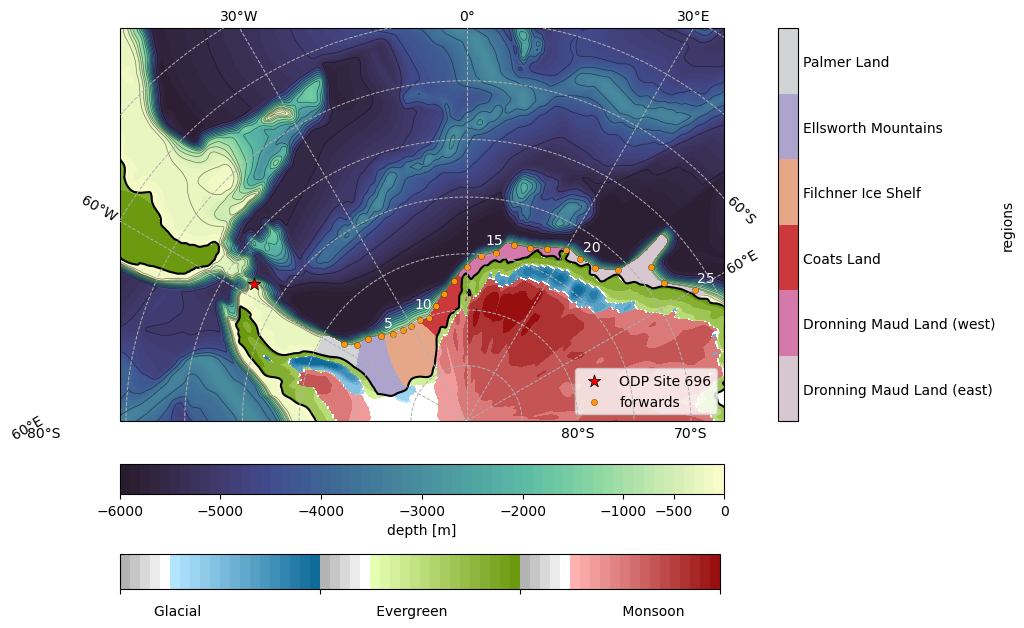

In [24]:
### General settings figure
print(f'Start plotting...')
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(10,7))
ax.set_extent([-60,40,-90,-55], ccrs.PlateCarree())

## Gridlines
# -60 W (fixed below)
gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl0.xlocator = mticker.FixedLocator(np.arange(-60,-55,60))
gl0.ylocator = mticker.FixedLocator([])
gl0.right_labels = True
gl0.bottom_labels = False
gl0.left_labels = True
gl0.top_labels = True

# 0 W/E
gl6 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl6.xlocator = mticker.FixedLocator(np.arange(0,5,60))
gl6.ylocator = mticker.FixedLocator([])
gl6.right_labels = True
gl6.bottom_labels = False
gl6.left_labels = True
gl6.top_labels = True
gl6.rotate_labels = False
gl6.ylabel_style = {'rotation':45}

# -30, 30 W/E
gl4 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl4.xlocator = mticker.FixedLocator(np.arange(-30,35,60))
gl4.ylocator = mticker.FixedLocator([])
gl4.right_labels = True
gl4.bottom_labels = False
gl4.left_labels = True
gl4.top_labels = True
gl4.rotate_labels = False
gl4.ylabel_style = {'rotation':-45}

# 85, 75, 65, 55, 50 S (only lines)
gl1 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl1.xlocator = mticker.FixedLocator([])
gl1.ylocator = mticker.FixedLocator([-85, -75, -65, -55, -50])
gl1.right_labels = False
gl1.bottom_labels = False
gl1.left_labels = False
gl1.top_labels = False
gl1.ylabel_style = {'rotation':0}

# 80, 70 S (fixed below)
gl2 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl2.xlocator = mticker.FixedLocator([])
gl2.ylocator = mticker.FixedLocator(np.arange(-90,-69,10))
gl2.right_labels = False
gl2.bottom_labels = True
gl2.left_labels = False
gl2.top_labels = False
gl2.rotate_labels = False

# 60 S (fixed below)
gl3 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl3.xlocator = mticker.FixedLocator([])
gl3.ylocator = mticker.FixedLocator(np.arange(-60,-50,10))
gl3.right_labels = False
gl3.bottom_labels = True
gl3.left_labels = False
gl3.top_labels = False
gl3.rotate_labels = False
gl3.ylabel_style = {'rotation':-45}

# 60 E (fixed below)
gl5 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
gl5.xlocator = mticker.FixedLocator(np.arange(60,65,60))
gl5.ylocator = mticker.FixedLocator([])
gl5.right_labels = True
gl5.bottom_labels = False
gl5.left_labels = True
gl5.top_labels = True

print(f'Base plotted, continue with data main figure...')

### Plot main figure
## Bathymetry and coastlines
im = ax.contourf(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=blevels, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree(), zorder=0)
jm = ax.contour(lons[:,875:2550], lats[:,875:2550], bath[:,875:2550], levels=dlevels, linewidths=0.5, alpha=0.5, colors="k", linestyles='-', transform=ccrs.PlateCarree(), zorder=1)
km = ax.contour(lons[:,875:2750], lats[:,875:2750], bath[:,875:2750], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)   # coastlines
# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label="depth [m]", pad=-.15, shrink=0.78, anchor=(0.0,0.0),
                    spacing='proportional', ticks=[-6000,-5000,-4000,-3000,-2000,-1000,-500,0])

# Rasterize the contour collections
for c in im.collections:
    c.set_rasterized(True)
for d in jm.collections:
    d.set_rasterized(True)
for e in km.collections:
    e.set_rasterized(True)

### Climate indices (Baatsen et al., in review)
lm = ax.contourf(ice2['lon'][:], ice2['lat'][:], ice2['II'][:,:], cmap=cm_toti, norm=mpl.colors.Normalize(vmin=0, vmax=1), transform=ccrs.PlateCarree(), zorder=0)
mm = ax.contourf(ice2['lon'][:], ice2['lat'][:], ice2['VI'][:,:], cmap=cm_tote, norm=mpl.colors.Normalize(vmin=0, vmax=1), transform=ccrs.PlateCarree(), zorder=0)
nm = ax.contourf(ice2['lon'][:], ice2['lat'][:], ice2['MI'][:,:], cmap=cm_totm, norm=mpl.colors.Normalize(vmin=0, vmax=1), transform=ccrs.PlateCarree(), zorder=0)

cax = plt.axes([0.125, -.025, 0.6, 0.05])
cb = mpl.colorbar.ColorbarBase(cax, orientation='horizontal', cmap=cm_tot, ticks=[0,1/3.,2/3.,1],
                               label='Glacial                                        Evergreen                                        Monsoon')
cb.ax.set_xticklabels([])

for f in lm.collections:
    f.set_rasterized(True)
for g in mm.collections:
    g.set_rasterized(True)
for h in nm.collections:
    h.set_rasterized(True)


## ODP 696
ax.scatter(x696, y696, color='red', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(), zorder=6, label='ODP Site 696')
## Release locations
ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=5,
           label='forwards',s=20, edgecolor='k', linewidths=0.2)
# ax.scatter(lonsbw, latsbw, transform=ccrs.PlateCarree(), color='tab:green', zorder=5,
#            label='backwards',s=20, edgecolor='k', linewidths=0.2)
ax.text(lonsfw[3]-1.2, latsfw[3]+1, '5', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[8]-10, latsfw[8]+.4, '10', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[13]-4, latsfw[13]+.6, '15', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[18]-.5, latsfw[18]+.7, '20', transform=ccrs.PlateCarree(), color='white')
ax.text(lonsfw[23]-1, latsfw[23]+.5, '25', transform=ccrs.PlateCarree(), color='white')
## Release regions
im2 = ax.contourf(lonsg[:825,:], latsg[:825,:], regg[:825,:], levels=[0,1,2,3,4,5,6,7],
            cmap=rmap, transform=ccrs.PlateCarree(), zorder=2)
ax.contourf(lonsl[:825,:], latsl[:825,:], regl[:825,:], levels=[0,1,2,3,4,5,6,7],
            cmap=rmap, transform=ccrs.PlateCarree(), zorder=2)
cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', label="regions", pad=.07, shrink=0.73)
cbar2.ax.set_ylim(1, 7)
cbar2.set_ticks([1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
cbar2.set_ticklabels(['Palmer Land', 'Ellsworth Mountains', 'Filchner Ice Shelf', 'Coats Land', 'Dronning Maud Land (west)', 'Dronning Maud Land (east)'])
cbar2.ax.tick_params(size=0)
cbar2.ax.invert_yaxis()

print(f'Main figure finished...')

ax.legend(loc='lower right')
plt.draw()

### Fix coordinate labels
for i, ea in enumerate(gl5.label_artists):
    if i == 0:
        pos = ea[2].get_position()
        ea[2].set_position([-450*pos[0], pos[1]])   # 60 E
    else:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for i, ea in enumerate(gl3.label_artists):
    if '-' in str(ea[2]):
        pos = gl3.label_artists[i+1][2].get_position()
        if i == 0:
            ea[2].set_position([-1.2*pos[0], pos[1]])   # 60 S
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

for i, ea in enumerate(gl2.label_artists):
    if '-' in str(ea[2]):
        pos = gl2.label_artists[i+1][2].get_position()
        if i == 0:
            ea[2].set_position([-3.8*pos[0], pos[1]])   # 80 S
        if i == 2:
            ea[2].set_position([-1.8*pos[0], pos[1]])   # 70 S
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

print(f'Saving figure as svg...')

plt.savefig('figures/Thesis/ReleaseLocations_complete.svg', dpi=600, bbox_inches='tight')
plt.show()

### Mean fields and ODP Site locations

Calculate mean fields over the five-year model period

In [38]:
data_path_ocean_POP = '/storage/shared/pop/p21a.EO38Ma.tx0.1.2pic_control/daily/'

files = sorted(glob(data_path_ocean_POP+'vars_first600m_eocene_2pic_pop_00*.nc'))

filename = data_path_ocean_POP+'vars_first600m_eocene_2pic_pop_00400301.nc'
for i, name in enumerate(files):
    if name == filename:
        files.pop(i)

In [39]:
uvel = np.zeros((1050,3600))
vvel = np.zeros_like(uvel)
temp = np.zeros_like(uvel)

for file in files:
    dat = xr.open_dataset(file)
    uvel += dat['UVEL'][0,0,:1050,:]
    vvel += dat['VVEL'][0,0,:1050,:]
    temp += dat['TEMP'][0,0,:1050,:]

In [40]:
uvel = uvel/len(files)
vvel = vvel/len(files)
temp = temp/len(files)

In [41]:
vel = np.sqrt(uvel**2 + vvel**2)/100.
velnan = vel.where(vel > 0)
tempnan = temp.where(temp > 0)

In [42]:
latsf = topo.variables['T_LAT_2D'][:,:]
lonsf = topo.variables['T_LON_2D'][:,:]
bathf = topo.variables['Bathymetry'][:,:]

### Fix coordinates uvel, vvel
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(lonsf[:1050,:], latsf[:1050,:], uvel)
uvel = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(lonsf[:1050,:], latsf[:1050,:], vvel)
vvel = np.concatenate((varg[:,2650:], varg[:,:850], varl[:,850:2650]), axis=1)

#### Mean fields

Fig. 2.2b

In [316]:
vals = [velnan, tempnan]
labelsz = ['mean surface velocity [m/s]', 'mean surface temperature [°C]']
cmaps = [cmo.cm.speed, cmo.cm.thermal]
vmaxes = [0.4, 20.]

Start plotting...
Saving figure...


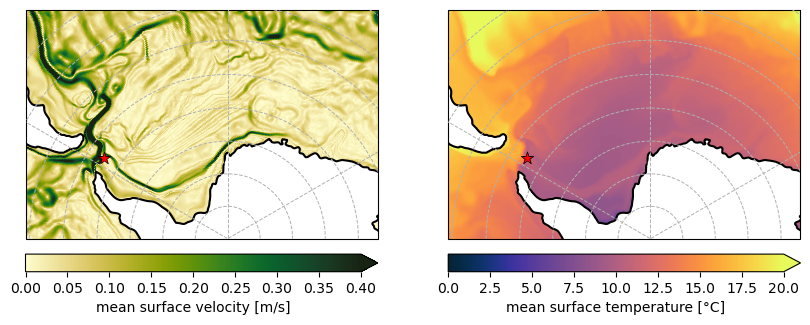

In [322]:
### General settings figure
print(f'Start plotting...')
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)}, figsize=(10,4))

for val, label, vm, cmap, ax in zip(vals, labelsz, vmaxes, cmaps, axes):
    ax.set_extent([-60,40,-90,-55], ccrs.PlateCarree())

    ## Gridlines
    # -60 W (fixed below)
    gl0 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
    gl0.xlocator = mticker.FixedLocator(np.arange(-60,65,60))
    gl0.ylocator = mticker.FixedLocator([])
    gl0.right_labels = False
    gl0.bottom_labels = False
    gl0.left_labels = False
    gl0.top_labels = False

    # 80, 70 S (fixed below)
    gl2 = ax.gridlines(linestyle='--', linewidth=.7, draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=7)
    gl2.xlocator = mticker.FixedLocator([])
    gl2.ylocator = mticker.FixedLocator(np.arange(-90,-45,5))
    gl2.right_labels = False
    gl2.bottom_labels = False
    gl2.left_labels = False
    gl2.top_labels = False
    gl2.rotate_labels = False

    ### Plot main figure
    ## Coastlines
    km = ax.contour(lons[:,875:2700], lats[:,875:2700], bath[:,875:2700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=3)   # coastlines
    ## Field
    ax.pcolormesh(lonsf[:1050,:850], latsf[:1050,:850], val[:,:850], transform=ccrs.PlateCarree(), vmin=0., vmax=vm, cmap=cmap)
    ax.pcolormesh(lonsf[:1050,850:2650], latsf[:1050,850:2650], val[:,850:2650], transform=ccrs.PlateCarree(), vmin=0., vmax=vm, cmap=cmap)
    im = ax.pcolormesh(lonsf[:1050,2650:], latsf[:1050,2650:], val[:,2650:], transform=ccrs.PlateCarree(), vmin=0., vmax=vm, cmap=cmap)
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, label=label, orientation='horizontal', pad=.05, extend='max')

    # Rasterize the contour collections
    for e in km.collections:
        e.set_rasterized(True)

    ## ODP 696
    ax.scatter(x696, y696, color='red', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(), zorder=6)

    ax.scatter(1, -78.3, transform=ccrs.PlateCarree(), color='white', zorder=4, s=35)

print(f'Saving figure...')
plt.savefig('figures/Thesis/Fields_zoom.png', dpi=600, bbox_inches='tight')
plt.show()

Fig. S4.2a

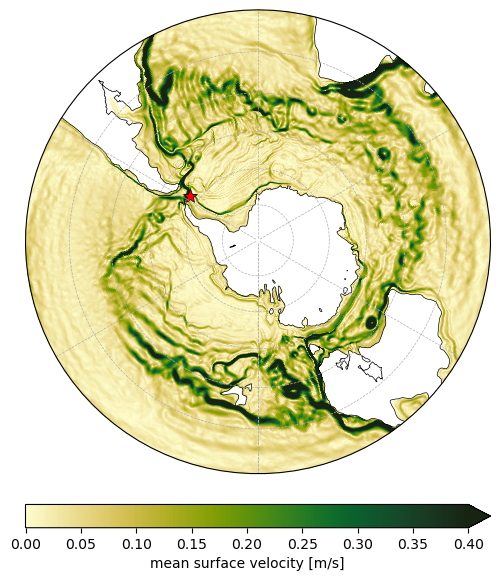

In [189]:
projection = ccrs.SouthPolarStereo()

### Plot fields and icebergs
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection}, figsize=(6,8))
ax.set_extent([-180,180,-90,-30], ccrs.PlateCarree())
ax.gridlines(linestyle='--', linewidth=.5)
ax.set_boundary(circle, transform=ax.transAxes)

# Field
ax.pcolormesh(lonsf[:1050,:850], latsf[:1050,:850], velnan[:,:850], transform=ccrs.PlateCarree(), vmin=0., vmax=.4, cmap=cmo.cm.speed)
ax.pcolormesh(lonsf[:1050,850:2650], latsf[:1050,850:2650], velnan[:,850:2650], transform=ccrs.PlateCarree(), vmin=0., vmax=.4, cmap=cmo.cm.speed)
im = ax.pcolormesh(lonsf[:1050,2650:], latsf[:1050,2650:], velnan[:,2650:], transform=ccrs.PlateCarree(), vmin=0., vmax=.4, cmap=cmo.cm.speed)
cb = fig.colorbar(im, ax=ax, label='mean surface velocity [m/s]', orientation='horizontal', pad=.05, extend='max')

# Create and plot contour coastlines
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(lonsf, latsf, bathf)
ax.contour(lonsg, latsg, varg, levels=[0], transform=ccrs.PlateCarree(), colors='k', linewidths=.5)
ax.contour(lonsl, latsl, varl, levels=[0], transform=ccrs.PlateCarree(), colors='k', linewidths=.5)

ax.plot(x696, y696, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree()) # Site 696

plt.savefig('figures/Thesis/MSV.png', bbox_inches='tight', dpi=600)
plt.show()

Fig. S4.2b

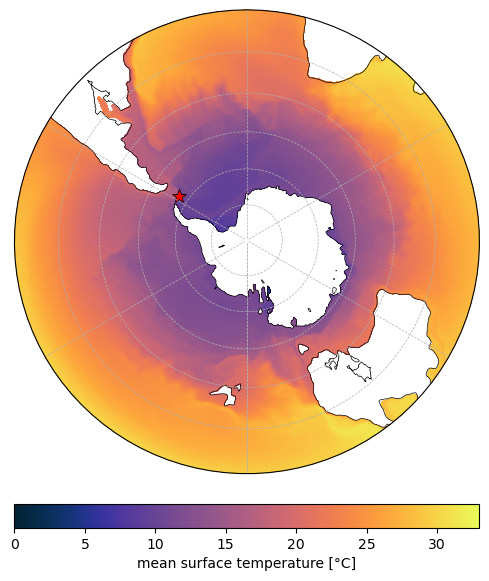

In [200]:
projection = ccrs.SouthPolarStereo()

### Plot fields and icebergs
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection}, figsize=(6,8))
# ax.set_title(f'Mean Surface Temperature')
ax.set_extent([-180,180,-90,-30], ccrs.PlateCarree())
ax.gridlines(linestyle='--', linewidth=.5)
ax.set_boundary(circle, transform=ax.transAxes)

# Field
ax.pcolormesh(lonsf[:1050,:850], latsf[:1050,:850], tempnan[:,:850], transform=ccrs.PlateCarree(), vmin=0., vmax=33., cmap=cmo.cm.thermal)
ax.pcolormesh(lonsf[:1050,850:2650], latsf[:1050,850:2650], tempnan[:,850:2650], transform=ccrs.PlateCarree(), vmin=0., vmax=33., cmap=cmo.cm.thermal)
im = ax.pcolormesh(lonsf[:1050,2650:], latsf[:1050,2650:], tempnan[:,2650:], transform=ccrs.PlateCarree(), vmin=0., vmax=33., cmap=cmo.cm.thermal)
cb = fig.colorbar(im, ax=ax, label='mean surface temperature [°C]', orientation='horizontal', pad=0.05)

# Create and plot contour coastlines
lonsg, lonsl, latsg, latsl, varg, varl = divide_longitude(lonsf, latsf, bathf)
ax.contour(lonsg, latsg, varg, levels=[0], transform=ccrs.PlateCarree(), colors='k', linewidths=.5)
ax.contour(lonsl, latsl, varl, levels=[0], transform=ccrs.PlateCarree(), colors='k', linewidths=.5)

ax.plot(x696, y696, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree()) # Site 696

plt.savefig('figures/Thesis/MST.png', bbox_inches='tight', dpi=600)
plt.show()

#### ODP locations

Figure S4.1 - supplements

Saving figure as svg...


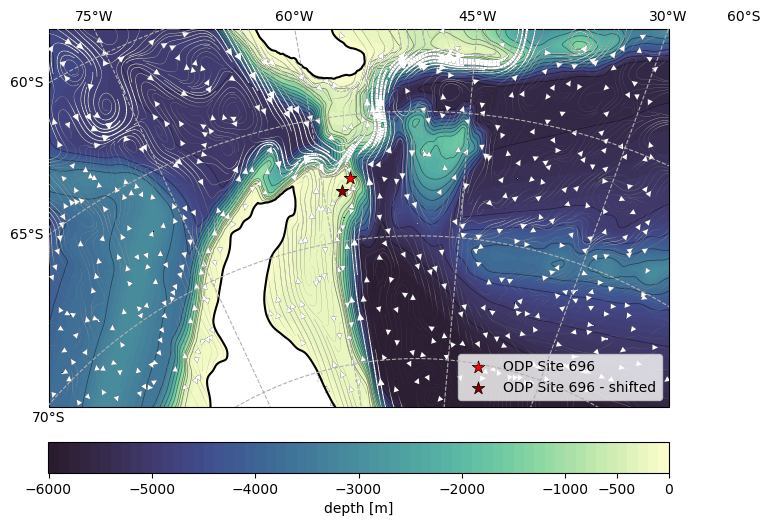

In [201]:
### Plot fields and icebergs
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=-50)}, figsize=(8,9))
ax.set_extent([-80., -30., -75., -60.])

### Gridlines
# -75, -60, -45, -30 W
gl0 = ax.gridlines(linestyle='--', draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=6)
gl0.xlocator = mticker.FixedLocator(np.arange(-75,-25,15))
gl0.ylocator = mticker.FixedLocator([])
gl0.right_labels = False
gl0.bottom_labels = False
gl0.left_labels = False
gl0.top_labels = True
gl0.rotate_labels = False

# 70, 65, 60 S
gl2 = ax.gridlines(linestyle='--', draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=6)
gl2.xlocator = mticker.FixedLocator([])
gl2.ylocator = mticker.FixedLocator(np.arange(-70,-59,5))
gl2.right_labels = False
gl2.bottom_labels = True
gl2.left_labels = True
gl2.top_labels = False
gl2.rotate_labels = False

# 75 S
gl1 = ax.gridlines(linestyle='--', draw_labels=True, x_inline=False, y_inline=False, crs=ccrs.PlateCarree(), zorder=6)
gl1.xlocator = mticker.FixedLocator([])
gl1.ylocator = mticker.FixedLocator(np.arange(-80,-70,5))
gl1.right_labels = False
gl1.bottom_labels = False
gl1.left_labels = False
gl1.top_labels = False
gl1.rotate_labels = False

### Bathymetry and coastlines
im = ax.contourf(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=blevels, cmap=cmo.cm.deep_r, transform=ccrs.PlateCarree(), zorder=0)
ax.contour(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=dlevels, linewidths=0.5, alpha=0.5, colors="k", linestyles='-', transform=ccrs.PlateCarree(), zorder=1)
ax.contour(lons[:650,800:1700], lats[:650,800:1700], bath[:650,800:1700], levels=[0], transform=ccrs.PlateCarree(), colors='k', zorder=4)   # coastlines
# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label="depth [m]", shrink=1, pad=.05, #pad=-.15, shrink=0.78, anchor=(0.0,0.0),
                    spacing='proportional', ticks=[-6000,-5000,-4000,-3000,-2000,-1000,-500,0])

### ODP Site 696
ax.scatter(x696, y696, color='red', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(), zorder=5, label='ODP Site 696')
ax.scatter(x696-1., y696-0.5, color='darkred', marker='*', s=90, edgecolors='black', linewidths=.5, transform=ccrs.PlateCarree(), zorder=5, label='ODP Site 696 - shifted')

### Mean ocean surface velocity
lw = 5.05 * np.sqrt((uvel[:650,800:1700])**2+(vvel[:650,800:1700])**2) / 200.
ax.streamplot(lons[:650,800:1700], lats[:650,800:1700], uvel[:650,800:1700], vvel[:650,800:1700], transform=ccrs.PlateCarree(),
              linewidth=lw, density=5, color='black', zorder=2)
lw = 5 * np.sqrt((uvel[:650,800:1700])**2+(vvel[:650,800:1700])**2) / 200.
ax.streamplot(lons[:650,800:1700], lats[:650,800:1700], uvel[:650,800:1700], vvel[:650,800:1700], transform=ccrs.PlateCarree(),
              linewidth=lw, density=5, color='white', zorder=3)

ax.legend(loc='lower right')
plt.draw()

### Fix coordinate labels
for i, ea in enumerate(gl2.label_artists):
    if '-' not in str(ea[2]):
        pos = ea[2].get_position()
        ea[2].set_position([1.3*pos[0], pos[1]])
    else:
        pos = ea[2].get_position()
        ea[2].set_position([pos[0], pos[1]])

print(f'Saving figure as svg...')
plt.savefig('figures/Thesis/ODPs.svg', dpi=300)
plt.show()

#### Zoom in trajectories bathymetry

In [247]:
datap = [C4g_filtered, C5g_filtered]
namesp = ['C4g', 'C5g']
labelsp = ['C4 icebergs', 'C5 icebergs']

Appendix E

Start preparing C4g...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Start preparing C5g...
   data prepared, continue plotting...
   trajectories reaching ODP plotted...
   other trajectories plotted...
Saving figure...
Figure saved.


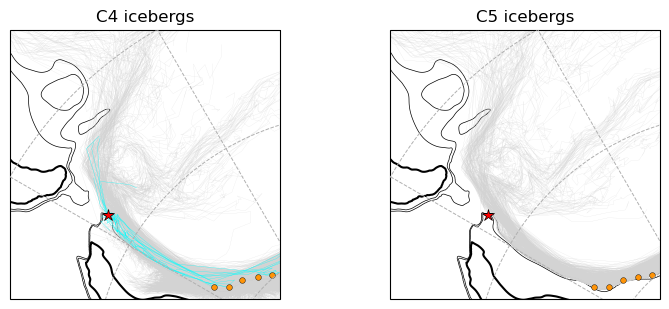

In [292]:
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(9,3.5))
axs = axs.flatten()

for dat, name, label, ax in zip(datap, namesp, labelsp, axs):
    print(f'Start preparing {name}...')
       
    ## Extract minimum values along second axis of distance array
    minvals = np.nanmin(dat['distance'], axis=1)
    
    ## Keep trajectories that reach within gridcell distance of ODP 696
    tst = np.tile(minvals,(len(dat['obs']),1))
    tlat = np.where(tst.T>gcd, np.nan, dat['lat'])
    tlon = np.where(tst.T>gcd, np.nan, dat['lon'])

    print(f'   data prepared, continue plotting...')
    
    ax = prepare_outline_plot_zoom(ax)
    ax.set_title(f'{str(label)}')
    
    ## Bathymetry and coastlines
    jm = ax.contour(lons[50:700,1000:1700], lats[50:700,1000:1700], bath[50:700,1000:1700], levels=[-500,-250], linewidths=0.5, colors="k",
                    linestyles='-', transform=ccrs.PlateCarree(), zorder=0)
    for d in jm.collections:
        d.set_rasterized(True)
    
    ## Plot ODP
    ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3) # Site 696
    
    ## Plot trajectories
    ax.plot(tlon.T, tlat.T, transform=ccrs.Geodetic(), linewidth=.2, zorder=2, color='cyan')
    print(f'   trajectories reaching ODP plotted...')
    ax.plot(dat['lon'].T, dat['lat'].T, transform=ccrs.Geodetic(), linewidth=.1, zorder=1, color='lightgrey')
    print(f'   other trajectories plotted...')
    
    ## Plot release locations
    ax.scatter(lonsfw, latsfw, transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3, label='forwards',s=17, edgecolor='k', linewidths=0.3)

print('Saving figure...')
plt.savefig(f'figures/Thesis/FW_Trajectories-zoom.png', bbox_inches='tight', dpi=600)
print(f'Figure saved.')
plt.show()

#### Longitudinal reach

Figure S4.3

Without delete particles kernel, particles will re-enter on the other side, but can they reach back to the SOM?

In [13]:
### Load data
pfile = xr.open_mfdataset('/nethome/5867800/passive/20p_5y_30d_1dt_2yr_circ.zarr', engine='zarr') # FW circumpolar

Saving figure...
Figure saved.


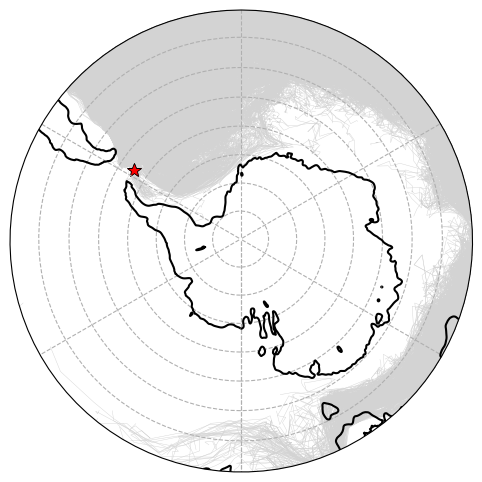

In [57]:
### Plot fields and icebergs
fig = plt.figure(figsize=(6,6))

# Setup axes
gs = gridspec.GridSpec(1,1)
ax = {}
ax0 = fig.add_subplot(gs[:,:], projection=ccrs.SouthPolarStereo())
ax0 = prepare_subplot_SPS(ax0)
# ax0.set_title(f'Passive Particles - circumpolar')

# Trajectories
ax0.plot(pfile['lon'].T, pfile['lat'].T, transform=ccrs.Geodetic(), linewidth=.3, zorder=0, color='lightgrey')

# ODP Site 696
ax0.plot(x696, y696, color='r', marker='*', markersize=10, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree()) # Site 696

print('Saving figure...')
plt.savefig(f'figures/Thesis/Circ_traj.png', bbox_inches='tight', dpi=600)
print(f'Figure saved.')
plt.show()

Saving figure...
Figure saved.


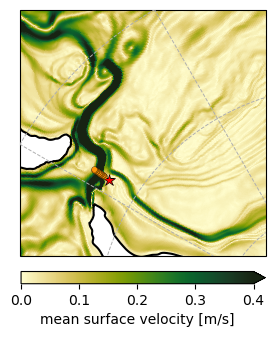

In [59]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                       subplot_kw={'projection': ccrs.SouthPolarStereo()},
                       figsize=(3.5,4))

ax = prepare_outline_plot_zoom(ax)

## Field
im = ax.pcolormesh(lonsf[:1050,:850], latsf[:1050,:850], velnan[:,:850], transform=ccrs.PlateCarree(), vmin=0., vmax=.4, cmap=cmo.cm.speed)
# Add colorbar
cb = fig.colorbar(im, ax=ax, label='mean surface velocity [m/s]', orientation='horizontal', pad=.05, extend='max', shrink=.9)

## Plot ODP
ax.plot(x696, y696, color='r', marker='*', markersize=9, markeredgecolor='black', markeredgewidth=.5, transform=ccrs.PlateCarree(), zorder=3) # Site 696

## Plot release locations
ax.scatter(np.linspace(-57., -57., num=20, endpoint=True), np.linspace(-67., -66., num=20, endpoint=True),
           transform=ccrs.PlateCarree(), color='xkcd:tangerine', zorder=3, label='forwards',s=17, edgecolor='k', linewidths=0.2)

print('Saving figure...')
plt.savefig(f'figures/Thesis/Circ_locs.png', bbox_inches='tight', dpi=600)
print(f'Figure saved.')
plt.show()